# Preparação e tratamento dos dados - Parte 2

## Objetivo

Este código tem como objetivo tratar a base "ans.csv" desenvolvida na parte 1

As etapas abordadas no tratamento de dados desenvolvido neste código são as seguintes:

1. Filtragem por tipo de contratação, porte e modalidade de operadora
1. Agrupamento das informações de receita, despesa e total de beneficiarios
1. Identificação e tratamento de dados outliers de receita e despesa
1. Criação da base para ser utilizada na etapa de forecast

## Este código aborda as informações do seguinte segmento:

### Empresarial - Modalidade Cooperativa Médica

In [5]:
#Bibliotecas
import os
import pandas as pd
import numpy as np
from functools import reduce
import matplotlib.pyplot as plt
from pandas.core.reshape.merge import merge
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

from IPython.display import display, Markdown

pd.set_option('display.max_rows', 999)
pd.set_option('display.max_columns', 999)
pd.set_option('display.width', 800)
pd.set_option('display.max_colwidth', None)
pd.options.display.float_format = '{:.6f}'.format

In [6]:
#Funções auxiliares

def sum_billion(x):    
    return round(((x.sum())/1000000000.0),2)

def sum_million(x):    
    return round(((x.sum())/1000000.0),2)

def media_agregada(x):    
    return round(((x.sum())/12.0),0)

### Seleção do Período para o tratamento dos dados

In [7]:
#Seleção do Periodo de análise

inicio = '2017-09-01'

fim = '2022-03-01'

Periodo = [inicio, fim]

### Parametros para filtragem dos dados

In [8]:
#Parametros para filtragem dos dados

contratacao_list = ['Adesao', 'Empresarial', 'Individual']

modalidade_list = ['Medicina de Grupo', 'Cooperativa Médica', 'Autogestão', 'Filantropia', 'Seguradora']

tipo_contratacao = 'Empresarial'

tipo_modalidade = 'Cooperativa Médica'

## Leitura dos dados

In [9]:
path = f'D:/TCC/tcc-main/codigos/preparacao_dados/analise_agrupadas' + '\\' + 'ans.csv'

ans = pd.read_csv(path, sep=';', decimal= ',', encoding='mbcs')  #Leitura da base

ans['ano'] = ans['ano'].astype('str')

ans['cd_ops'] = ans['cd_ops'].astype('str')

ans['lg_cancelada'] = ans['lg_cancelada'].astype('str')

ans['lg_nova_ops'] = ans['lg_nova_ops'].astype('str')

ans['ano'] = pd.PeriodIndex(ans['ano'], freq="Y")

ans['trimestre'] = pd.PeriodIndex(ans['trimestre'], freq="Q")

#Filtrando os dados até 2021
ans = ans[(ans.ano > '2017') & (ans.ano < '2022')]

ans = ans.replace(' NaN', np.NaN)

ans = ans.dropna()

#Filtra somente as operadas com flag ativas
ans_filt = ans[(ans['lg_cancelada']!='1.0') & (ans['benef']!=np.nan)].reset_index(drop=True)

ans_filt.head()

,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,receita,despesa,benef,lg_cancelada,lg_nova_ops
0,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/03/2018,2018Q1,791860.200000,0.000000,722.000000,0.0,0.0
1,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2018,2018Q2,769499.340000,0.000000,731.000000,0.0,0.0
2,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/09/2018,2018Q3,846654.020000,0.000000,774.000000,0.0,0.0
3,2018,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/12/2018,2018Q4,903017.550000,0.000000,787.000000,0.0,0.0
4,2019,300012,CEMIL CENTRO MEDICO DE ITU LTDA.,Medicina de Grupo,Pequeno,P,Adesao,Pre-estabelecido,01/06/2019,2019Q2,1801080.840000,0.000000,775.000000,0.0,0.0


In [10]:
ans_filt_cont_mod = ans_filt[ (ans_filt['contratacao'] == tipo_contratacao) & 
                              (ans_filt['modalidade'] == tipo_modalidade)].reset_index(drop=True)

ans_filt_cont_mod = ans_filt_cont_mod[['ano', 'cd_ops', 'razao_social', 'modalidade', 'port_ops', 'vigencia', 'contratacao', 'financiamento', 'trimestre', 'receita', 'despesa', 'benef']]

ans_filt_cont_mod.head()


,ano,cd_ops,razao_social,modalidade,port_ops,vigencia,contratacao,financiamento,trimestre,receita,despesa,benef
0,2018,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Empresarial,Pos-estabelecido,2018Q1,92342.860000,74138.820000,4552.000000
1,2018,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Empresarial,Pos-estabelecido,2018Q2,267289.300000,230521.410000,5375.000000
2,2018,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Empresarial,Pos-estabelecido,2018Q3,473080.610000,346458.200000,6166.000000
3,2018,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Empresarial,Pos-estabelecido,2018Q4,501899.560000,338757.870000,6604.000000
4,2019,300136,UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA.,Cooperativa Médica,Médio,P,Empresarial,Pos-estabelecido,2019Q1,660174.080000,448527.120000,6911.000000


In [11]:
ans_filt_cont_mod[['ano','cd_ops','trimestre','receita','despesa','benef','modalidade','port_ops','contratacao']].to_csv('emp_coopmed.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_filt_cont_mod.groupby(['ano','cd_ops','razao_social','trimestre']).agg({'receita':lambda x: sum_million(x),'despesa':lambda x: sum_million(x)}).head()

receita  despesa
ano  cd_ops razao_social                                     trimestre                   
2018 300136 UNIMED LITORAL SUL/RS - COOPERATIVA MÉDICA LTDA. 2018Q1    12.000000 8.530000
                                                             2018Q2    10.350000 8.780000
                                                             2018Q3     8.760000 7.270000
                                                             2018Q4     8.830000 4.070000
     300713 UNIMED DE ASSIS COOPERATIVA DE TRABALHO MÉDICO   2018Q1     3.160000 5.620000

### Agregação dos valores de receita e despesa e quantidade de beneficiarios

In [12]:
ans_filt_cont_mod_agrup = ans_filt_cont_mod.groupby(['ano','trimestre'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                               'despesa':lambda x: sum_million(x),
                                                                                               'benef': 'sum',
                                                                                               'cd_ops':lambda x: x.nunique()})

ans_filt_cont_mod_agrup['pct_despesa'] = ans_filt_cont_mod_agrup.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_filt_cont_mod_agrup.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_filt_cont_mod_agrup = ans_filt_cont_mod_agrup[(ans_filt_cont_mod_agrup.trimestre > '2017Q4') & (ans_filt_cont_mod_agrup.trimestre < '2022Q1')]

ans_filt_cont_mod_agrup[['n_ops','benef']] = ans_filt_cont_mod_agrup[['n_ops','benef']].astype('int')

ans_filt_cont_mod_agrup.set_index('trimestre', inplace=True)

ans_filt_cont_mod_agrup

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,6472.460000,4971.760000,9202155,265,76.810000
2018Q2,7199.910000,5883.550000,9670538,268,81.720000
2018Q3,7294.470000,5991.820000,9753175,268,82.140000
2018Q4,12582.140000,9302.670000,9690011,266,73.940000
2019Q1,7158.500000,5638.380000,9387204,264,78.760000
2019Q2,7520.440000,6281.770000,9513432,265,83.530000
2019Q3,8204.350000,6933.190000,9779938,266,84.510000
2019Q4,7971.620000,6767.010000,9828190,267,84.890000
2020Q1,8091.360000,6307.600000,9896684,266,77.950000


## As próximas etapas tratam da identificação de outliers e tratamentes desses dados com problemas

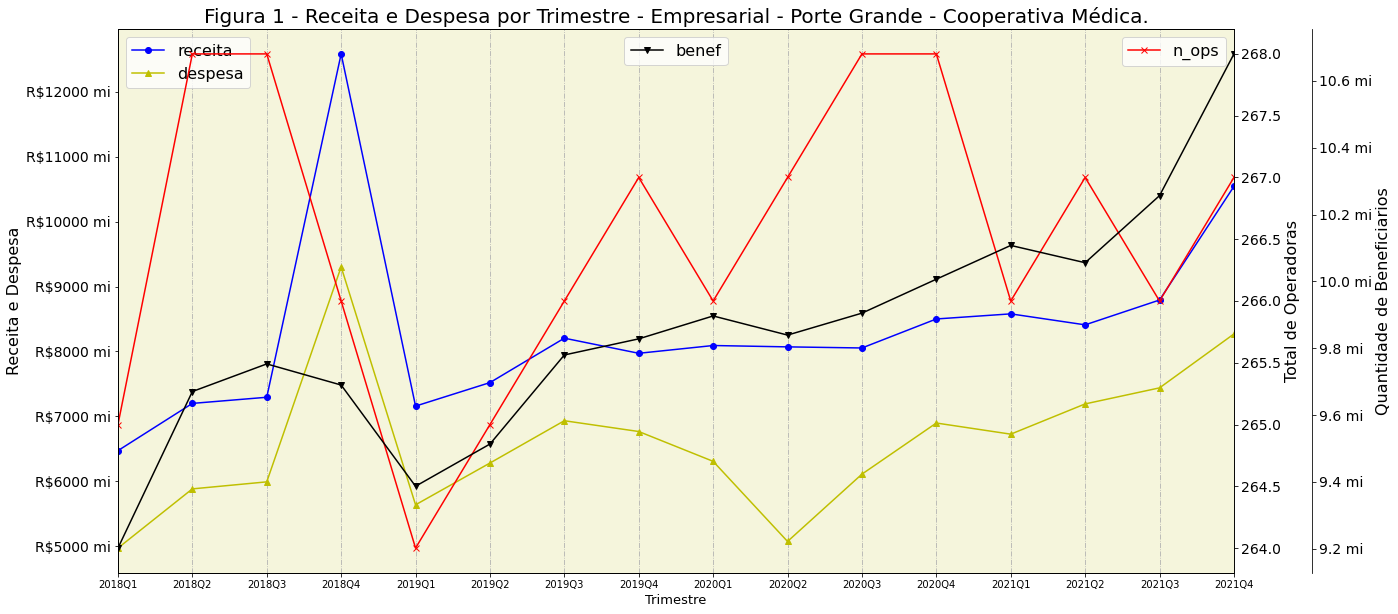

In [13]:
df_plot = ans_filt_cont_mod_agrup.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Empresarial - Porte Grande - Cooperativa Médica.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} mi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks, fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1000000) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

plt.show()

del df_plot

In [14]:
#Cria o rankin das operadoras com maior receita e despesa
ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':lambda x: sum_million(x),
                                                                                                           'despesa':lambda x: sum_million(x),
                                                                                                           'benef': 'sum'}).reset_index(drop=True)

ans_filt_cont_mod_agrup_ops = ans_filt_cont_mod_agrup_ops.sort_values(['benef'],ascending = False).groupby('trimestre').head(100).reset_index()

ans_filt_cont_mod_agrup_ops.head()

,index,ano,cd_ops,trimestre,receita,despesa,benef
0,3745,2021,339679,2021Q4,1654.990000,1287.120000,1746700.000000
1,3744,2021,339679,2021Q3,1586.770000,1367.510000,1714737.000000
2,3743,2021,339679,2021Q2,1439.020000,1240.920000,1676942.000000
3,2676,2020,339679,2020Q3,1310.050000,974.450000,1602302.000000
4,3742,2021,339679,2021Q1,1389.180000,1175.700000,1593918.000000


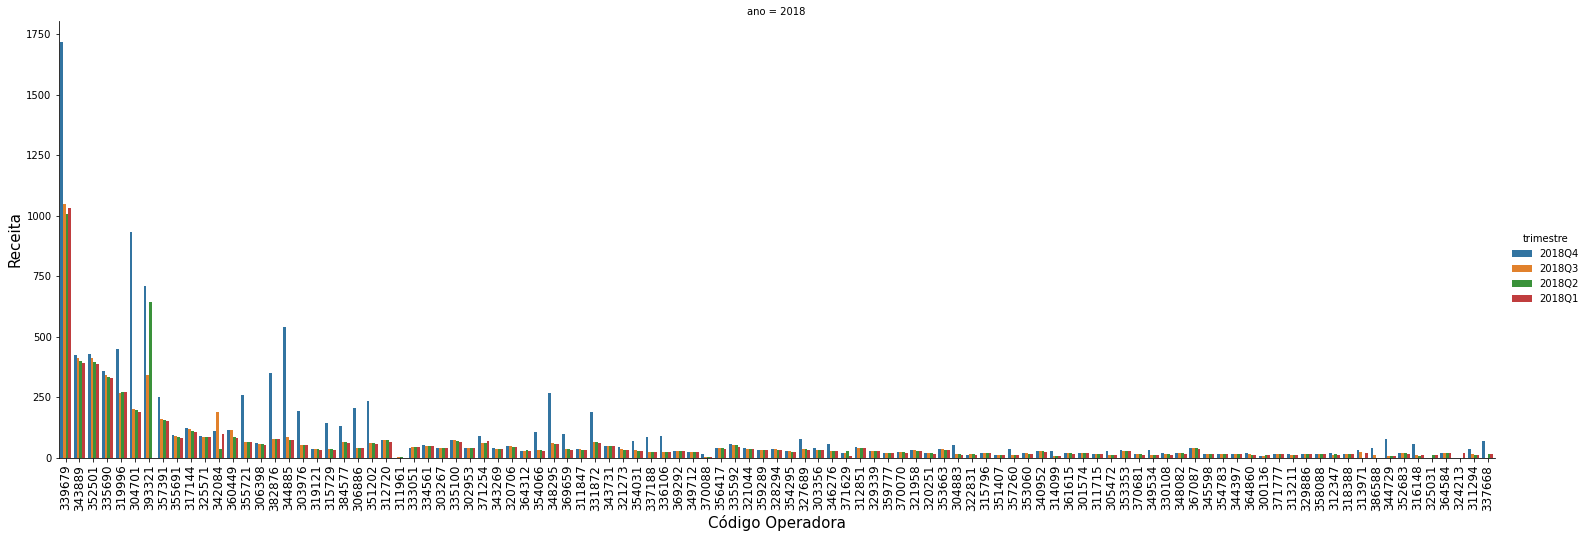

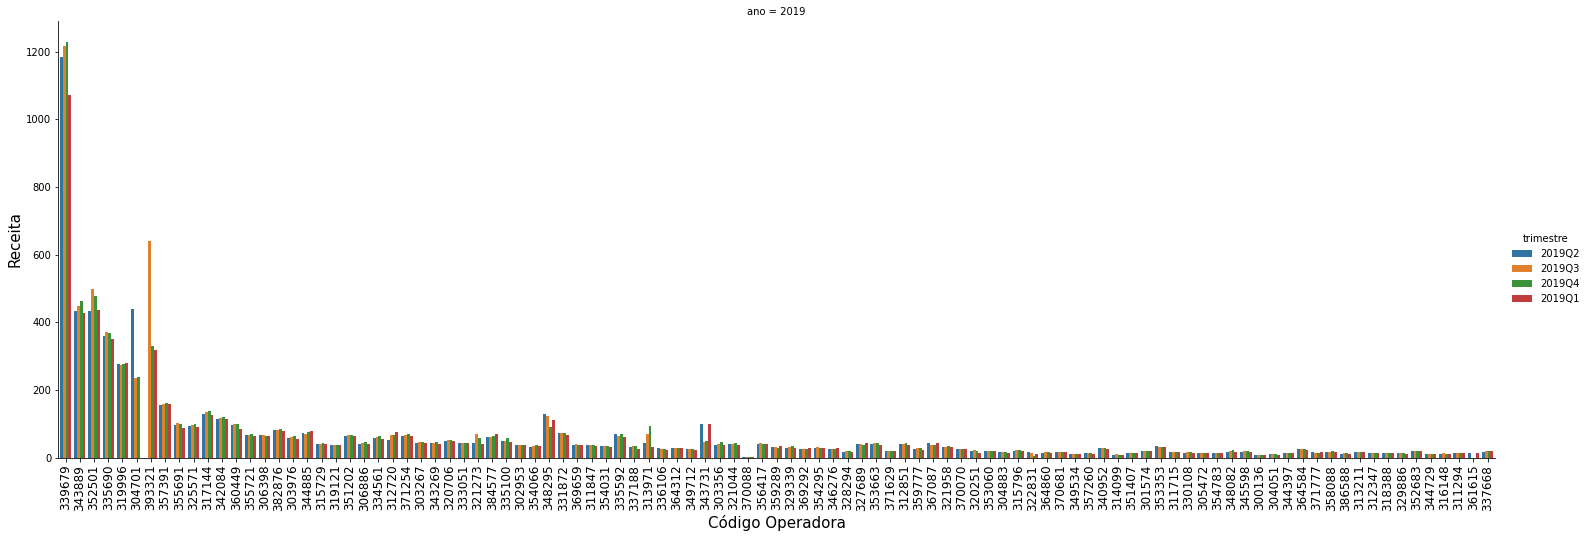

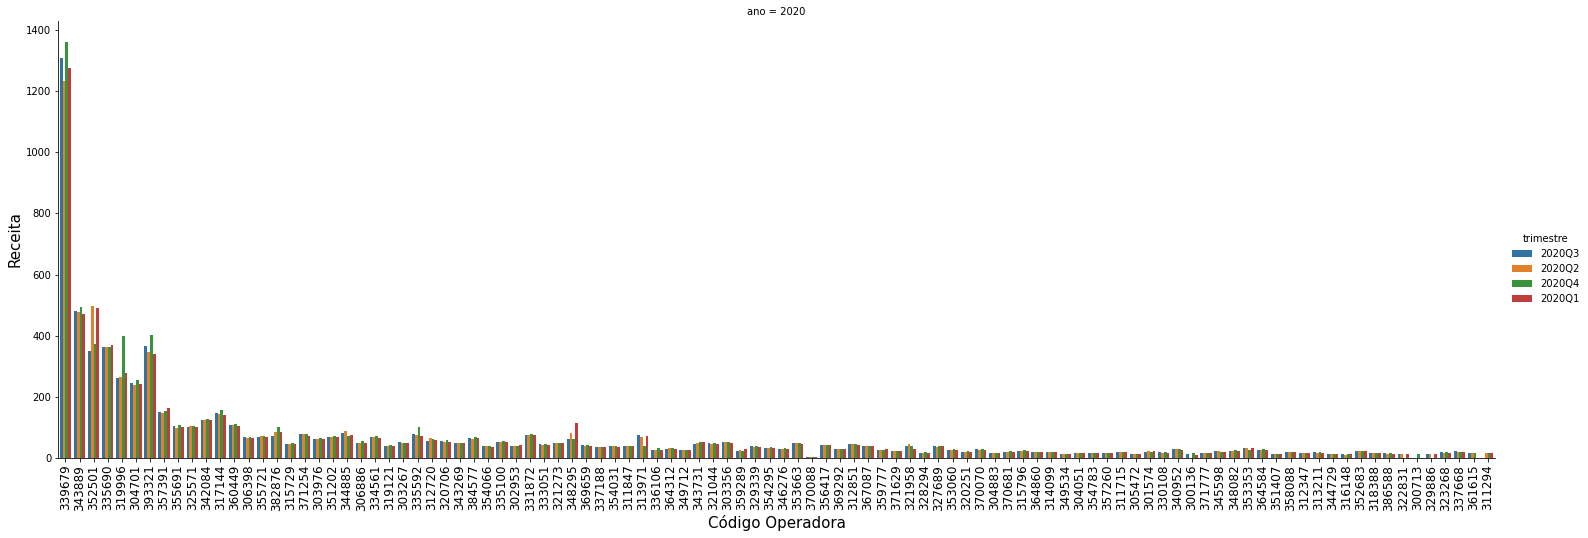

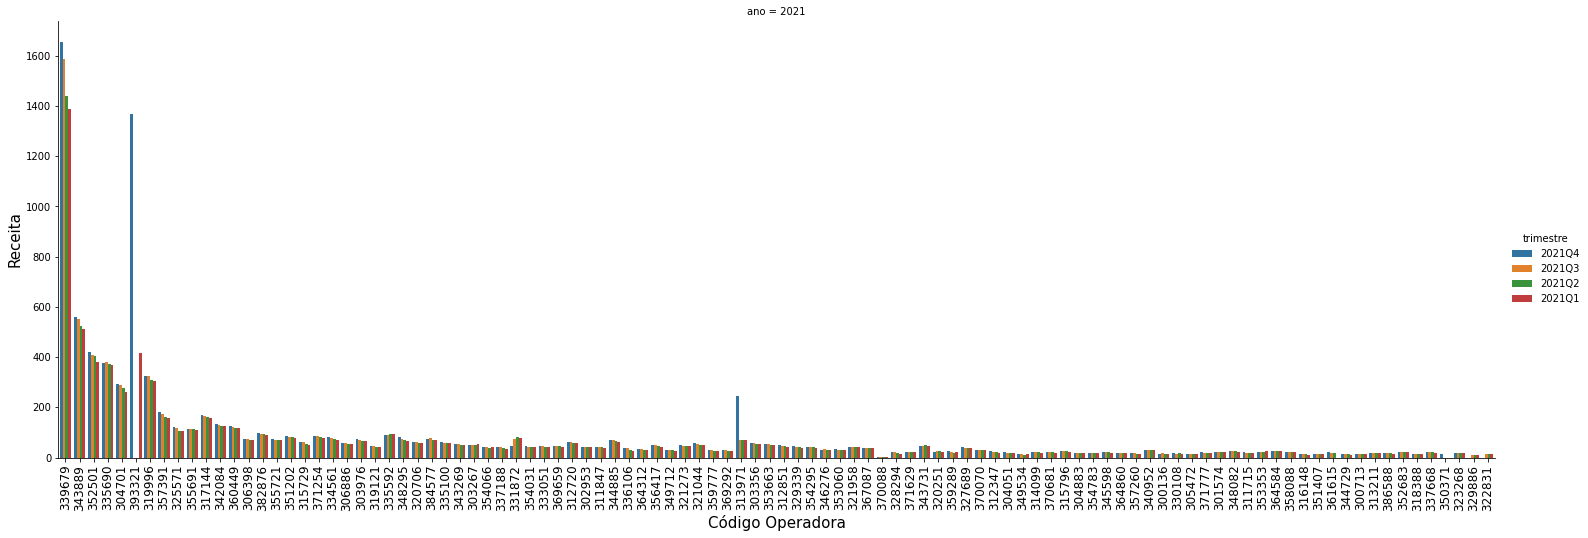

In [15]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

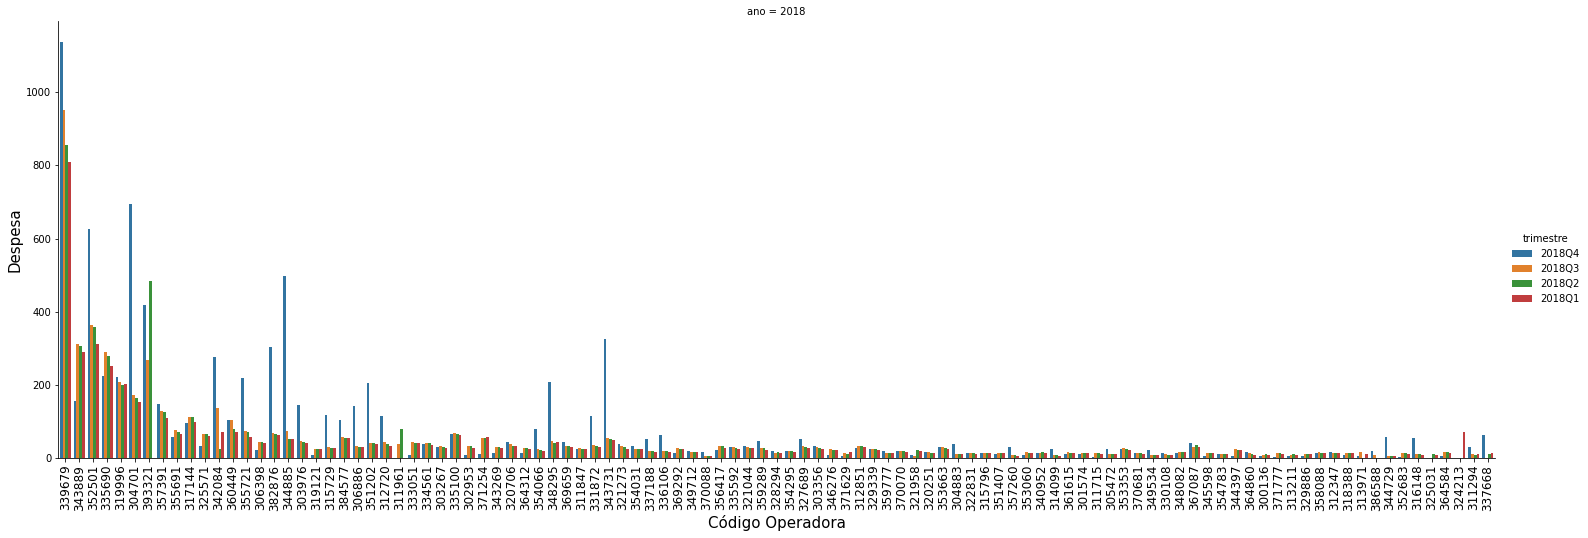

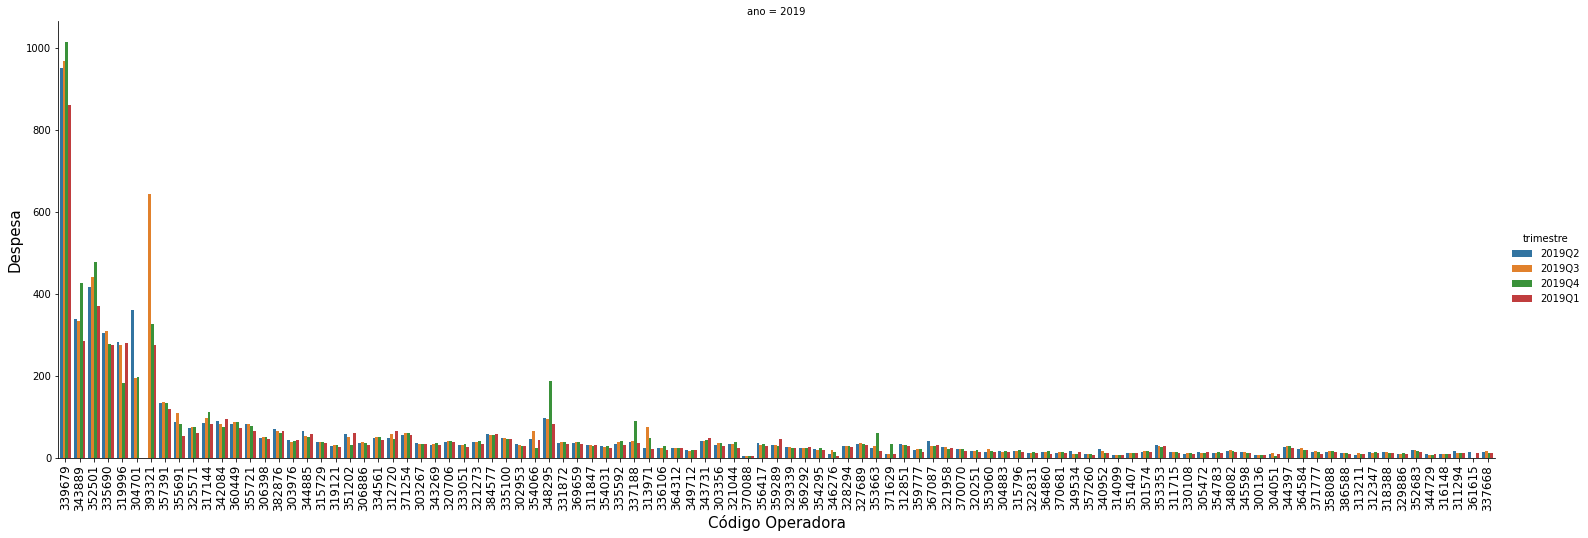

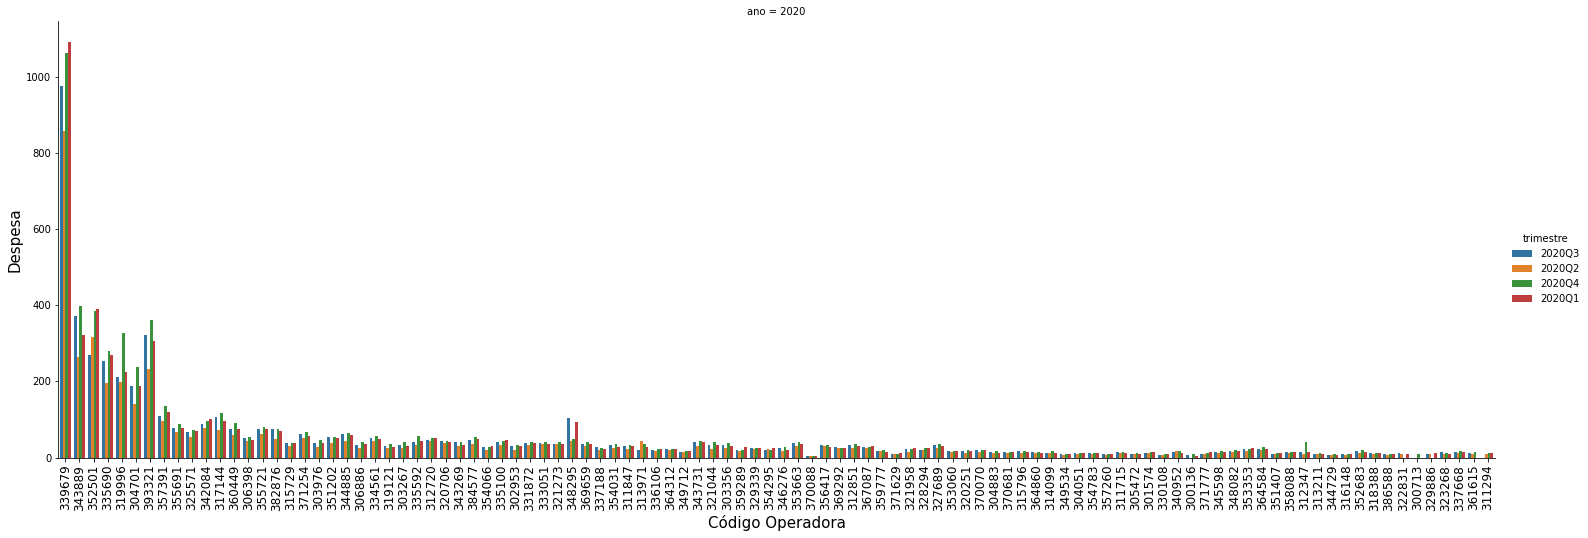

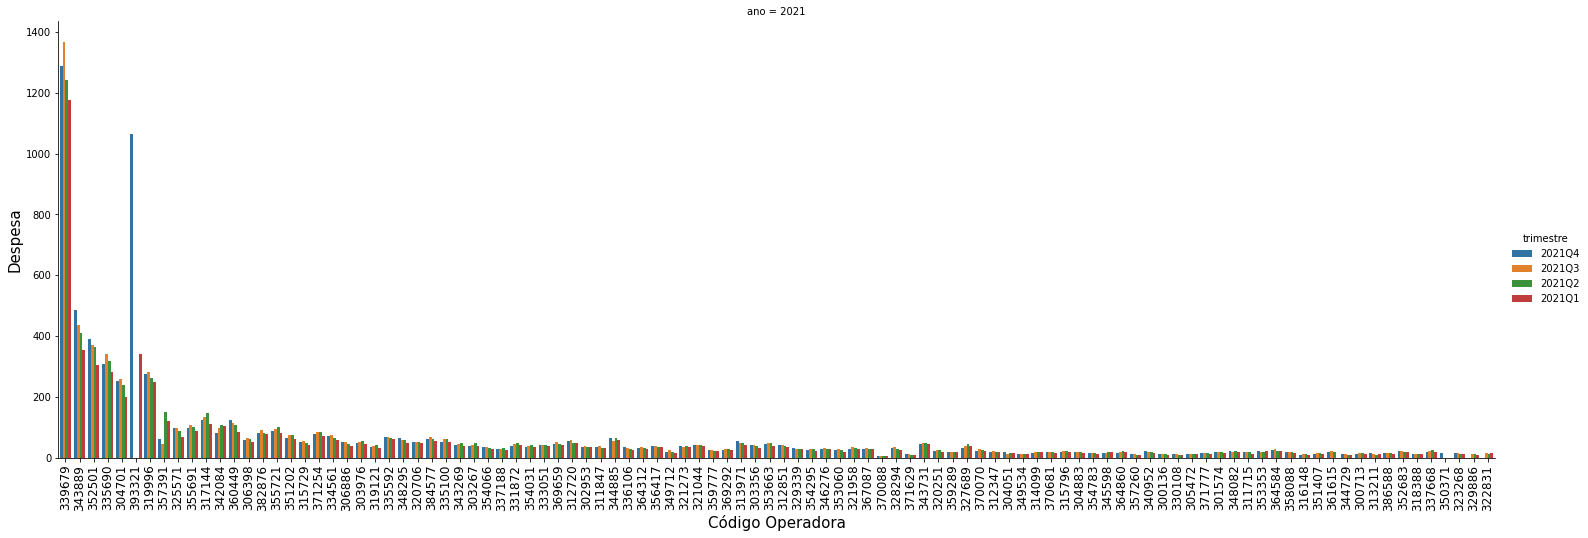

In [16]:
df_plot = ans_filt_cont_mod_agrup_ops.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)
ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)
ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)
ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

### Limpeza e Tratamento de Dados dos outliers

Nos gráficos acima é possivel observar que as curvas de receita e despesas possuem pontos outliers, provavelmente ocasionados pelo por erros de lançamentos das demonstrações contabeis.

E além disso, nos gráficos de barras por operadoras, mostra que muitas operadoras não possuem lançamentos em todos os trimestres do ano. Essas ausencias de lançamentos também ajudam no aparecimento de pontos outliers na evolução trimestral de receita e despesa.

Os códigos das células abaixo, tem com objetivo corrigir essas falhas de lançamentos de demontrações contabeis trimestrais. E na última parte do tratamento, possui o objetivo de corrigir alguns desvios do da curva de receita e depesa trimestral.

#### 1ª Etapa - Preenchendo lançamentos faltantes de algumas operadoras


In [17]:
ans_alterada1 = ans_filt_cont_mod.groupby(['ano','cd_ops','trimestre'], as_index=False).agg({'receita':'sum',
                                                                                             'despesa':'sum'})

ans_alterada1 = ans_alterada1[(ans_alterada1['ano']>'2017') & (ans_alterada1['ano']<'2022')] #Filtra anos de 2018 até 2021

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita != 0) & (ans_alterada1.despesa == 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa != 0)].index)

ans_alterada1 = ans_alterada1.drop(ans_alterada1[(ans_alterada1.receita == 0) & (ans_alterada1.despesa == 0)].index)

display(ans_alterada1.head())

,ano,cd_ops,trimestre,receita,despesa
0,2018,300136,2018Q1,11998036.020000,8534399.230000
1,2018,300136,2018Q2,10346163.300000,8775384.340000
2,2018,300136,2018Q3,8764161.650000,7271328.080000
3,2018,300136,2018Q4,8831205.600000,4067178.990000
4,2018,300713,2018Q1,3160036.250000,5621268.280000


In [18]:
ans_alterada2 = ans_alterada1.groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))

#ans_alterada2.n_trimestre.unique()

ans_alterada2.head()

,ano,cd_ops,n_trimestre
0,2018,300136,4
1,2018,300713,4
2,2018,301060,4
3,2018,301124,4
4,2018,301574,4


In [20]:
#Operadoras com lançamento contabeis em todos os trimestres do período selecionado para o estudo
ans_alterada_complete = ans_alterada2[ans_alterada2['n_trimestre']==4].reset_index(drop=True)
ans_alterada_complete = ans_alterada_complete[['ano','cd_ops']]

display(ans_alterada_complete.info())

display(ans_alterada_complete.head())


#ans_alterada_complete[ans_alterada_complete['cd_ops']=='393321']

complete_ops_list = ans_alterada_complete['cd_ops'].to_numpy()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1035 entries, 0 to 1034
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     1035 non-null   period[A-DEC]
 1   cd_ops  1035 non-null   object       
dtypes: object(1), period[A-DEC](1)
memory usage: 16.3+ KB


None

,ano,cd_ops
0,2018,300136
1,2018,300713
2,2018,301060
3,2018,301124
4,2018,301574


In [21]:
#Operadoras com lançamento contabeis faltando em algum(uns) trimestre(s) do período selecionado para o estudo
ans_alterada_imcomplete = ans_alterada2[ans_alterada2['n_trimestre']!=4].reset_index(drop=True)
ans_alterada_imcomplete = ans_alterada_imcomplete[['ano','cd_ops']]

display(ans_alterada_imcomplete.info())

display(ans_alterada_imcomplete.head())


imcomplete_ops_list = ans_alterada_imcomplete['cd_ops'].to_numpy()

#ans_alterada_imcomplete[ans_alterada_imcomplete['cd_ops']=='393321']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     23 non-null     period[A-DEC]
 1   cd_ops  23 non-null     object       
dtypes: object(1), period[A-DEC](1)
memory usage: 496.0+ bytes


None

,ano,cd_ops
0,2018,302228
1,2018,309907
2,2018,311961
3,2018,341819
4,2018,343765


In [22]:
diff_list = np.setdiff1d(complete_ops_list,imcomplete_ops_list)

ans_alterada_complete = ans_alterada_complete[ans_alterada_complete["cd_ops"].isin(diff_list)]

#Dataframe somente com as operadoras com lançamentos completos
display(ans_alterada_complete.info())

display(ans_alterada_complete.head())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1003 entries, 0 to 1033
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype        
---  ------  --------------  -----        
 0   ano     1003 non-null   period[A-DEC]
 1   cd_ops  1003 non-null   object       
dtypes: object(1), period[A-DEC](1)
memory usage: 23.5+ KB


None

,ano,cd_ops
0,2018,300136
1,2018,300713
2,2018,301060
3,2018,301124
4,2018,301574


In [23]:
#Filtra as operadoras com lançamentos completos
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada3 =  ans_alterada1[i1.isin(i2)]

#diops_tcc_analise3[diops_tcc_analise3['receita']==0]

display(ans_alterada3.head())

#Verificação da filtragem
ans_alterada3_vef = ans_alterada3[(ans_alterada3['ano']>'2017') & (ans_alterada3['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada3_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300136,2018Q1,11998036.020000,8534399.230000
1,2018,300136,2018Q2,10346163.300000,8775384.340000
2,2018,300136,2018Q3,8764161.650000,7271328.080000
3,2018,300136,2018Q4,8831205.600000,4067178.990000
4,2018,300713,2018Q1,3160036.250000,5621268.280000


array([4], dtype=int64)

In [24]:
#Cálculo do percentual de crescimento entre os trimestres
ans_alterada3['ref1'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str))

ans_alterada3['ref2'] = (   ans_alterada3['ano'].map(str) + 
                            ans_alterada3['cd_ops'].map(str)+
                            ans_alterada3['trimestre'].map(str))

ans_alterada3[['receita_shifted','despesa_shifted']] = ans_alterada3[['ref1','ref2','receita','despesa']].groupby(['ref1'])[['receita','despesa']].shift()

ans_alterada3['pct_tri_receita'] = ((ans_alterada3['receita'] / ans_alterada3['receita_shifted'])) 
ans_alterada3['pct_tri_despesa'] = ((ans_alterada3['despesa'] / ans_alterada3['despesa_shifted'])) 
 
ans_alterada3 = ans_alterada3[['ano','cd_ops','trimestre','receita','receita_shifted','pct_tri_receita','despesa','despesa_shifted','pct_tri_despesa']].fillna(0)

ans_alterada3.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa
0,2018,300136,2018Q1,11998036.020000,0.000000,0.000000,8534399.230000,0.000000,0.000000
1,2018,300136,2018Q2,10346163.300000,11998036.020000,0.862321,8775384.340000,8534399.230000,1.028237
2,2018,300136,2018Q3,8764161.650000,10346163.300000,0.847093,7271328.080000,8775384.340000,0.828605
3,2018,300136,2018Q4,8831205.600000,8764161.650000,1.007650,4067178.990000,7271328.080000,0.559345
4,2018,300713,2018Q1,3160036.250000,0.000000,0.000000,5621268.280000,0.000000,0.000000


In [25]:
stats_ans_alterada = pd.DataFrame(ans_alterada3.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75]))

stats_ans_alterada = stats_ans_alterada.reset_index(level=[0,1])

stats_ans_alterada.columns = ['_'.join(col) for col in stats_ans_alterada.columns.values]

stats_ans_alterada = stats_ans_alterada[['ano_','trimestre_','pct_tri_receita_25%', 'pct_tri_receita_75%', 'pct_tri_despesa_25%', 'pct_tri_despesa_75%']]

stats_ans_alterada.rename(columns = {'ano_':'ano',
                                     'trimestre_':'trimestre',
                                     'pct_tri_receita_25%':'pct_tri_receita_25',
                                     'pct_tri_receita_75%':'pct_tri_receita_75',
                                     'pct_tri_despesa_25%':'pct_tri_despesa_25',
                                     'pct_tri_despesa_75%':'pct_tri_despesa_75'}, inplace = True)

stats_ans_alterada

,ano,trimestre,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,2018Q1,0.000000,0.000000,0.000000,0.000000
1,2018,2018Q2,1.007432,1.053754,1.000349,1.151234
2,2018,2018Q3,1.010396,1.061621,0.972279,1.110586
3,2018,2018Q4,1.019962,1.580618,0.560733,1.733712
4,2019,2019Q1,0.000000,0.000000,0.000000,0.000000
5,2019,2019Q2,0.998698,1.049566,1.021726,1.207741
6,2019,2019Q3,1.000126,1.055268,0.957552,1.125848
7,2019,2019Q4,1.000325,1.060486,0.902618,1.091161
8,2020,2020Q1,0.000000,0.000000,0.000000,0.000000
9,2020,2020Q2,0.988795,1.030766,0.720863,0.919476


In [26]:
ans_alterada4 =  pd.merge(ans_alterada3, stats_ans_alterada, how = 'left', on = ['ano','trimestre'])

ans_alterada4 = ans_alterada4[( (ans_alterada4['pct_tri_receita'] >= ans_alterada4['pct_tri_receita_25']) & 
                                (ans_alterada4['pct_tri_receita'] <= ans_alterada4['pct_tri_receita_75'])) &
                                ((ans_alterada4['pct_tri_despesa'] >= ans_alterada4['pct_tri_despesa_25']) & 
                                (ans_alterada4['pct_tri_despesa'] <= ans_alterada4['pct_tri_despesa_75']))]

ans_alterada4.head()

,ano,cd_ops,trimestre,receita,receita_shifted,pct_tri_receita,despesa,despesa_shifted,pct_tri_despesa,pct_tri_receita_25,pct_tri_receita_75,pct_tri_despesa_25,pct_tri_despesa_75
0,2018,300136,2018Q1,11998036.020000,0.000000,0.000000,8534399.230000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,2018,300713,2018Q1,3160036.250000,0.000000,0.000000,5621268.280000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,2018,301060,2018Q1,4921440.780000,0.000000,0.000000,4545467.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
10,2018,301060,2018Q3,5550750.170000,5237270.610000,1.059856,4981594.370000,4703403.650000,1.059147,1.010396,1.061621,0.972279,1.110586
12,2018,301124,2018Q1,3425727.190000,0.000000,0.000000,2585948.180000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [27]:
stats_ans_alterada2 = ans_alterada4.groupby(['ano','trimestre'])[['pct_tri_receita','pct_tri_despesa']].describe(percentiles = [.25,.5,.75])

stats_ans_alterada2 = stats_ans_alterada2.reset_index(level=[0,1])

stats_ans_alterada2.columns = ['_'.join(col) for col in stats_ans_alterada2.columns.values]

stats_ans_alterada2 = stats_ans_alterada2[['ano_','trimestre_','pct_tri_receita_50%', 'pct_tri_despesa_50%']]

stats_ans_alterada2.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_tri_receita_50%':'pct_tri_receita_50',
                                      'pct_tri_despesa_50%':'pct_tri_despesa_50'}, inplace = True)

stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,0.000000,0.000000
1,2018,2018Q2,1.025693,1.080749
2,2018,2018Q3,1.033574,1.032140
3,2018,2018Q4,1.053898,0.993480
4,2019,2019Q1,0.000000,0.000000
5,2019,2019Q2,1.026788,1.096760
6,2019,2019Q3,1.032495,1.027789
7,2019,2019Q4,1.026114,1.023133
8,2020,2020Q1,0.000000,0.000000
9,2020,2020Q2,1.009842,0.819119


In [28]:
stats_ans_alterada2 = stats_ans_alterada2.replace(0.0, 1.0)

stats_ans_alterada2[['pct_tri_receita_50_l1','pct_tri_despesa_50_l1']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50','pct_tri_despesa_50']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

stats_ans_alterada2['pct_tri_receita_50_m1'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l1']

stats_ans_alterada2['pct_tri_despesa_50_m1'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l1']

stats_ans_alterada2[['pct_tri_receita_50_l2','pct_tri_despesa_50_l2']] = stats_ans_alterada2.groupby(['ano'])[['pct_tri_receita_50_m1','pct_tri_despesa_50_m1']].shift()

stats_ans_alterada2.fillna(1.0, inplace=True)

stats_ans_alterada2['pct_tri_receita_50_m2'] = stats_ans_alterada2['pct_tri_receita_50'] * stats_ans_alterada2['pct_tri_receita_50_l2']

stats_ans_alterada2['pct_tri_despesa_50_m2'] = stats_ans_alterada2['pct_tri_despesa_50'] * stats_ans_alterada2['pct_tri_despesa_50_l2']

stats_ans_alterada2 = stats_ans_alterada2[['ano','trimestre','pct_tri_receita_50_m2','pct_tri_despesa_50_m2']]

stats_ans_alterada2.rename(columns = {'pct_tri_receita_50_m2':'pct_tri_receita_50',
                                      'pct_tri_despesa_50_m2':'pct_tri_despesa_50'}, inplace = True)

stats_ans_alterada2

,ano,trimestre,pct_tri_receita_50,pct_tri_despesa_50
0,2018,2018Q1,1.000000,1.000000
1,2018,2018Q2,1.025693,1.080749
2,2018,2018Q3,1.060130,1.115485
3,2018,2018Q4,1.117268,1.108211
4,2019,2019Q1,1.000000,1.000000
5,2019,2019Q2,1.026788,1.096760
6,2019,2019Q3,1.060154,1.127237
7,2019,2019Q4,1.087839,1.153313
8,2020,2020Q1,1.000000,1.000000
9,2020,2020Q2,1.009842,0.819119


In [29]:
keys = list(ans_alterada_complete.columns.values)
i1 = ans_alterada1.set_index(keys).index
i2 = ans_alterada_complete.set_index(keys).index

ans_alterada5 =  ans_alterada1[~i1.isin(i2)]

#Retira as operadoras que so possuem lançamentos de receita ou despesa
ans_alterada5 = ans_alterada5[((ans_alterada5['receita']!=0.0)&(ans_alterada5['despesa']!=0.0))]

display(ans_alterada5.head())

#display(ans_alterada5[ans_alterada5['cd_ops']=='393321'])

ans_alterada5_vef = ans_alterada5[(ans_alterada5['ano']>'2017') & (ans_alterada5['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
ans_alterada5_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
24,2018,302228,2018Q2,2770521.870000,2391706.560000
25,2018,302228,2018Q3,1650813.390000,1527859.920000
26,2018,302228,2018Q4,1816924.240000,561638.980000
71,2018,304701,2018Q1,188960715.750000,152276462.750000
72,2018,304701,2018Q2,198149694.530000,163192566.150000


array([3, 4, 2, 1], dtype=int64)

In [30]:
#Agrupamento duplo, ou seja, agurpamento da receita e despesa por operadora e trimestre
ans_alterada6 = ans_alterada5[['cd_ops','trimestre','receita','despesa']]
ans_alterada6 = ans_alterada6.set_index(['cd_ops','trimestre'])
mux = pd.MultiIndex.from_product([ans_alterada6.index.levels[0], ans_alterada6.index.levels[1]],names=['cd_ops','trimestre'])
ans_alterada6 = ans_alterada6.reindex(mux, fill_value=0).reset_index()

ans_alterada6['ano'] = ans_alterada6['trimestre'].dt.year

ans_alterada6['ano'] = ans_alterada6['ano'].apply(pd.Period, freq='A-DEC')

ans_alterada6 = ans_alterada6[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada6.sort_values(by=['ano','cd_ops'], ignore_index=True, inplace=True)

#ans_alterada6[ans_alterada6['cd_ops']=='393321']

ans_alterada6.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,0.000000,0.000000
1,2018,302228,2018Q2,2770521.870000,2391706.560000
2,2018,302228,2018Q3,1650813.390000,1527859.920000
3,2018,302228,2018Q4,1816924.240000,561638.980000
4,2018,304701,2018Q1,188960715.750000,152276462.750000


In [31]:
ans_alterada7 = ans_alterada6.groupby(['ano','cd_ops'], as_index=False).agg({   'receita': 'sum',
                                                                                'despesa': 'sum'})

#Criação dos campos de receita e despesa anuais dividida por 4
ans_alterada7['receita_tri'] = ans_alterada7['receita'] / 4.0
ans_alterada7['despesa_tri'] = ans_alterada7['despesa'] / 4.0

ans_alterada7.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,302228,6238259.500000,4481205.460000,1559564.875000,1120301.365000
1,2018,304701,1523823913.260000,1181553700.540000,380955978.315000,295388425.135000
2,2018,309907,76706672.530000,60116727.840000,19176668.132500,15029181.960000
3,2018,310131,12105563.950000,12831937.540000,3026390.987500,3207984.385000
4,2018,311961,1963297.810000,113778920.110000,490824.452500,28444730.027500


In [32]:
ans_alterada8 =  pd.merge(ans_alterada6, ans_alterada7[['ano','cd_ops','receita_tri','despesa_tri']], how = 'outer', on = ['ano','cd_ops'])

ans_alterada8 = ans_alterada8[['ano','cd_ops','trimestre','receita_tri','despesa_tri']]

ans_alterada8.rename(columns = {'receita_tri':'receita', 'despesa_tri':'despesa'}, inplace = True)

#Retira as operadoras que possuem receita ou despesa iguais a zero
ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita == 0) & (ans_alterada8.despesa == 0)].index)

#Retira as operadoras que possuem receita ou despesa negativos
ans_alterada8 = ans_alterada8.drop(ans_alterada8[(ans_alterada8.receita < 1.0) | (ans_alterada8.despesa < 1.0)].index)

#ans_alterada8[ans_alterada8['cd_ops']=='393321']

ans_alterada8.head()

#ans_alterada8_vef = ans_alterada8[(ans_alterada8['ano']>'2017') & (ans_alterada8['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#ans_alterada8_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,1559564.875000,1120301.365000
1,2018,302228,2018Q2,1559564.875000,1120301.365000
2,2018,302228,2018Q3,1559564.875000,1120301.365000
3,2018,302228,2018Q4,1559564.875000,1120301.365000
4,2018,304701,2018Q1,380955978.315000,295388425.135000


In [33]:
#Aplicando o percentual de crescimento ao df com os valores distribuido de forma igual a cada trimestre
ans_alterada9 = pd.merge(ans_alterada8,stats_ans_alterada2, on=['ano','trimestre'])

ans_alterada9['receita_m1'] = ans_alterada9['receita'] * ans_alterada9['pct_tri_receita_50']

ans_alterada9['despesa_m1'] = ans_alterada9['despesa'] * ans_alterada9['pct_tri_despesa_50']

ans_alterada9 = ans_alterada9[['ano','cd_ops','trimestre','receita_m1','despesa_m1']]

ans_alterada9.rename(columns = {'receita_m1':'receita', 'despesa_m1':'despesa'}, inplace = True)

#ans_alterada9[ans_alterada9['cd_ops']=='393321']
 
ans_alterada9.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,1559564.875000,1120301.365000
1,2018,304701,2018Q1,380955978.315000,295388425.135000
2,2018,309907,2018Q1,19176668.132500,15029181.960000
3,2018,310131,2018Q1,3026390.987500,3207984.385000
4,2018,311961,2018Q1,490824.452500,28444730.027500


In [34]:
# Calculando as diferenças dos valores totais de receita e despesa antes e depois da correção
ans_alterada10 = ans_alterada9.groupby(['ano','cd_ops'], as_index=False).agg({  'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada10.rename(columns = {'receita':'receita2', 'despesa':'despesa2'}, inplace = True)

ans_alterada10 = pd.merge(ans_alterada10, ans_alterada7, on=['ano','cd_ops'])

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita','despesa','receita2','despesa2']]

ans_alterada10['receita_diff'] = ans_alterada10['receita2'] - ans_alterada10['receita']

ans_alterada10['despesa_diff'] = ans_alterada10['despesa2'] - ans_alterada10['despesa']

ans_alterada10['receita_tri_diff'] = ans_alterada10['receita_diff'] / 4.0
ans_alterada10['despesa_tri_diff'] = ans_alterada10['despesa_diff'] / 4.0

ans_alterada10 = ans_alterada10[['ano','cd_ops','receita_tri_diff','despesa_tri_diff']]

ans_alterada10.head()

,ano,cd_ops,receita_tri_diff,despesa_tri_diff
0,2018,302228,79183.241225,85267.558661
1,2018,304701,19342144.472896,22482387.913582
2,2018,309907,973650.255256,1143890.112465
3,2018,310131,153657.889740,244163.762786
4,2018,311961,24920.458036,2164964.501514


In [35]:
ans_alterada11 =  pd.merge(ans_alterada9, ans_alterada10, how = 'outer', on = ['ano','cd_ops'])

ans_alterada11['receita_final'] = ans_alterada11['receita'] - ans_alterada11['receita_tri_diff']

ans_alterada11['despesa_final'] = ans_alterada11['despesa'] - ans_alterada11['despesa_tri_diff']

ans_alterada11 = ans_alterada11[['ano','cd_ops','trimestre','receita_final','despesa_final']]

ans_alterada11.rename(columns = {'receita_final':'receita', 'despesa_final':'despesa'}, inplace = True)

ans_alterada11.head()

#ans_alterada11[ans_alterada11['cd_ops']=='304701']

,ano,cd_ops,trimestre,receita,despesa
0,2018,302228,2018Q1,1480381.633775,1035033.806339
1,2018,302228,2018Q2,1520451.115602,1125496.952480
2,2018,302228,2018Q3,1574157.787607,1164411.425899
3,2018,302228,2018Q4,1663268.963016,1156263.275282
4,2018,304701,2018Q1,361613833.842104,272906037.221418


In [36]:
ans_alterada12 = ans_alterada11.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita': 'sum',
                                                                                'despesa': 'sum'})

ans_alterada12['receita_tri'] = ans_alterada12['receita'] / 4.0
ans_alterada12['despesa_tri'] = ans_alterada12['despesa'] / 4.0

ans_alterada12.head()

,ano,cd_ops,receita,despesa,receita_tri,despesa_tri
0,2018,302228,6238259.500000,4481205.460000,1559564.875000,1120301.365000
1,2018,304701,1523823913.260000,1181553700.540000,380955978.315000,295388425.135000
2,2018,309907,76706672.530000,60116727.840000,19176668.132500,15029181.960000
3,2018,310131,12105563.950000,12831937.540000,3026390.987500,3207984.385000
4,2018,311961,1963297.810000,113778920.110000,490824.452500,28444730.027500


In [37]:
ans_alterada13 = ans_alterada3[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada14 = pd.concat([ans_alterada13, ans_alterada11], ignore_index=True)

#diops_tcc_analise14[diops_tcc_analise14['cd_ops']=='304701']

ans_alterada14.head()

#diops_tcc_analise_vef = diops_tcc_analise14[(diops_tcc_analise14['ano']>'2017') & (diops_tcc_analise14['ano']<'2022')].groupby(['ano','cd_ops'], as_index=False).agg(n_trimestre = ('trimestre','nunique'))
#diops_tcc_analise_vef['n_trimestre'].unique()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300136,2018Q1,11998036.020000,8534399.230000
1,2018,300136,2018Q2,10346163.300000,8775384.340000
2,2018,300136,2018Q3,8764161.650000,7271328.080000
3,2018,300136,2018Q4,8831205.600000,4067178.990000
4,2018,300713,2018Q1,3160036.250000,5621268.280000


In [38]:
ans_alterada15 = ans_alterada14.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada15['pct_despesa'] = ans_alterada15.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada15.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

ans_alterada15 = ans_alterada15[['trimestre','receita','despesa','n_ops','pct_despesa']]

ans_alterada15.set_index('trimestre', inplace=True)

ans_alterada15

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,7.040000,5.380000,261,76.420000
2018Q2,7.140000,5.770000,261,80.810000
2018Q3,7.550000,6.150000,261,81.460000
2018Q4,11.800000,8.820000,261,74.750000
2019Q1,7.380000,5.830000,265,79.000000
2019Q2,7.640000,6.440000,265,84.290000
2019Q3,7.860000,6.600000,265,83.970000
2019Q4,7.980000,6.750000,265,84.590000
2020Q1,8.110000,6.330000,266,78.050000


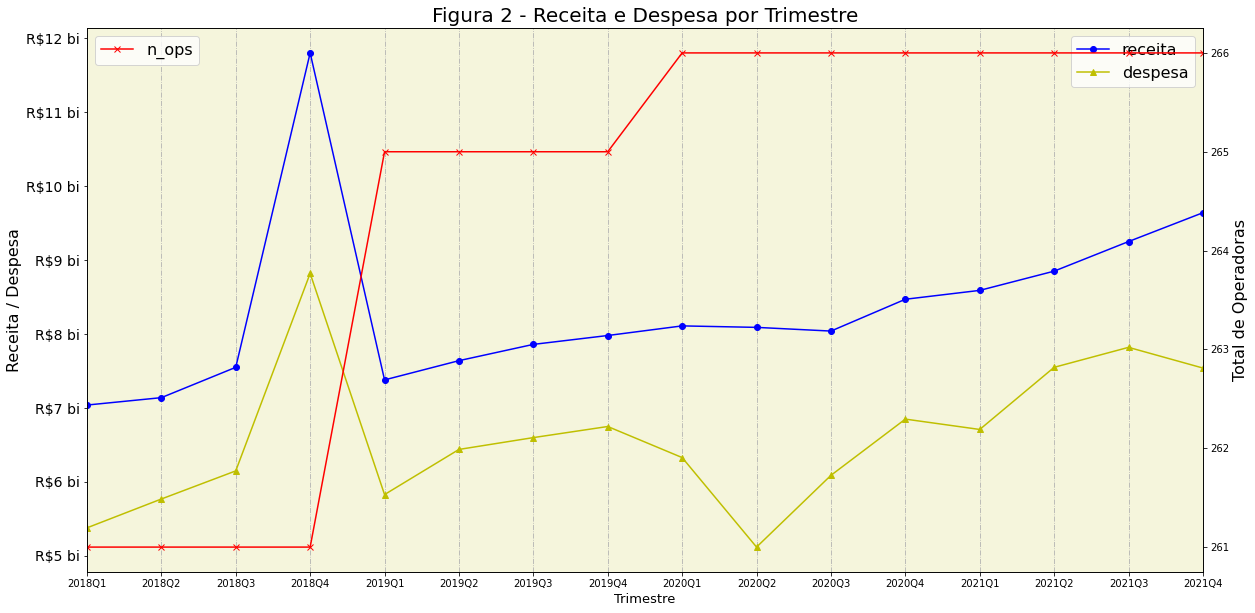

In [39]:
df_plot = ans_alterada15.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.savefig('emp_coopmed_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [40]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada16.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada16.head()

,ano,cd_ops,receita,despesa
135,2018,339679,4803.860000,3755.040000
256,2018,393321,1690.790000,1166.190000
148,2018,343889,1626.890000,1061.810000
177,2018,352501,1620.600000,1659.370000
18,2018,304701,1523.820000,1181.550000


In [41]:
ans_alterada_ops = ans_alterada16.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada14.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada16 =  ans_alterada14[i1.isin(i2)]

ans_alterada16.sort_values(by=['receita'], ascending=False, inplace=True)

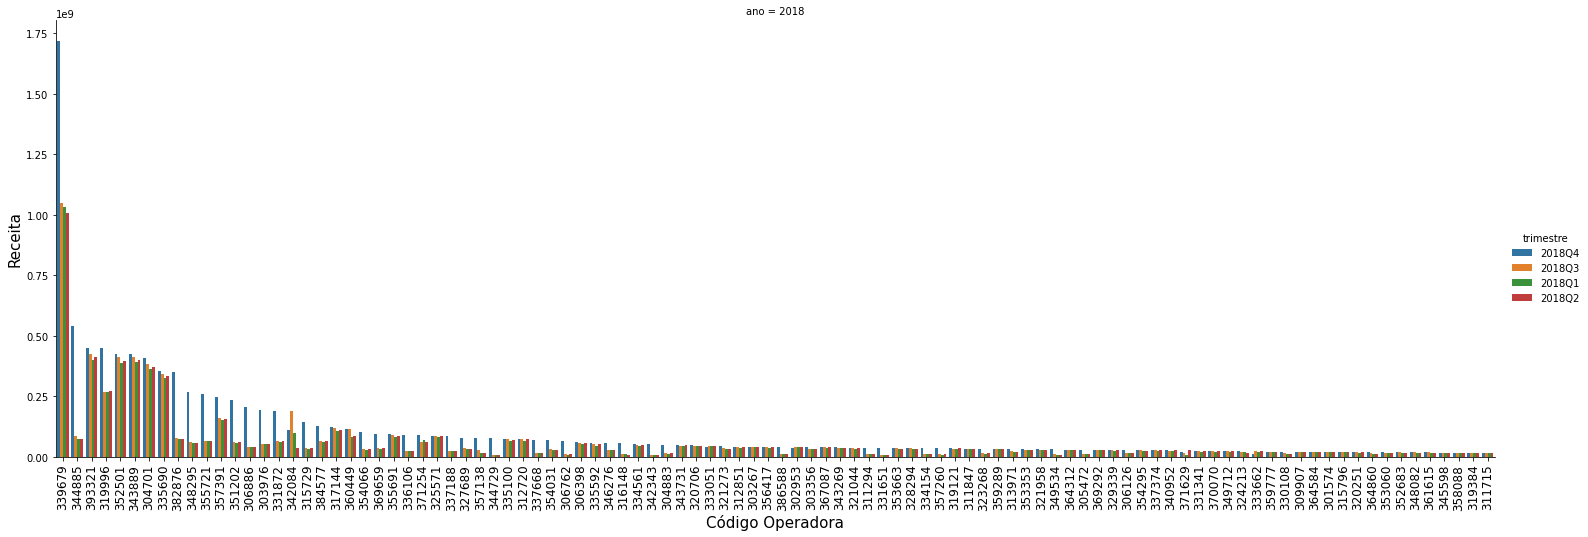

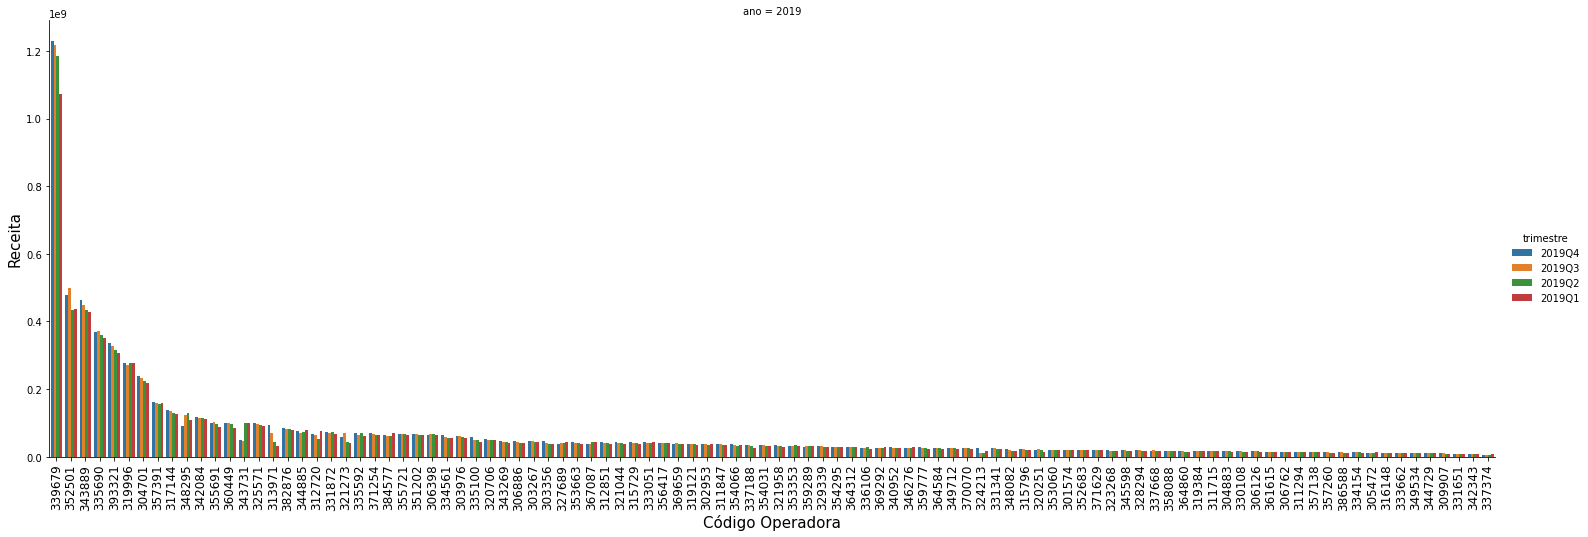

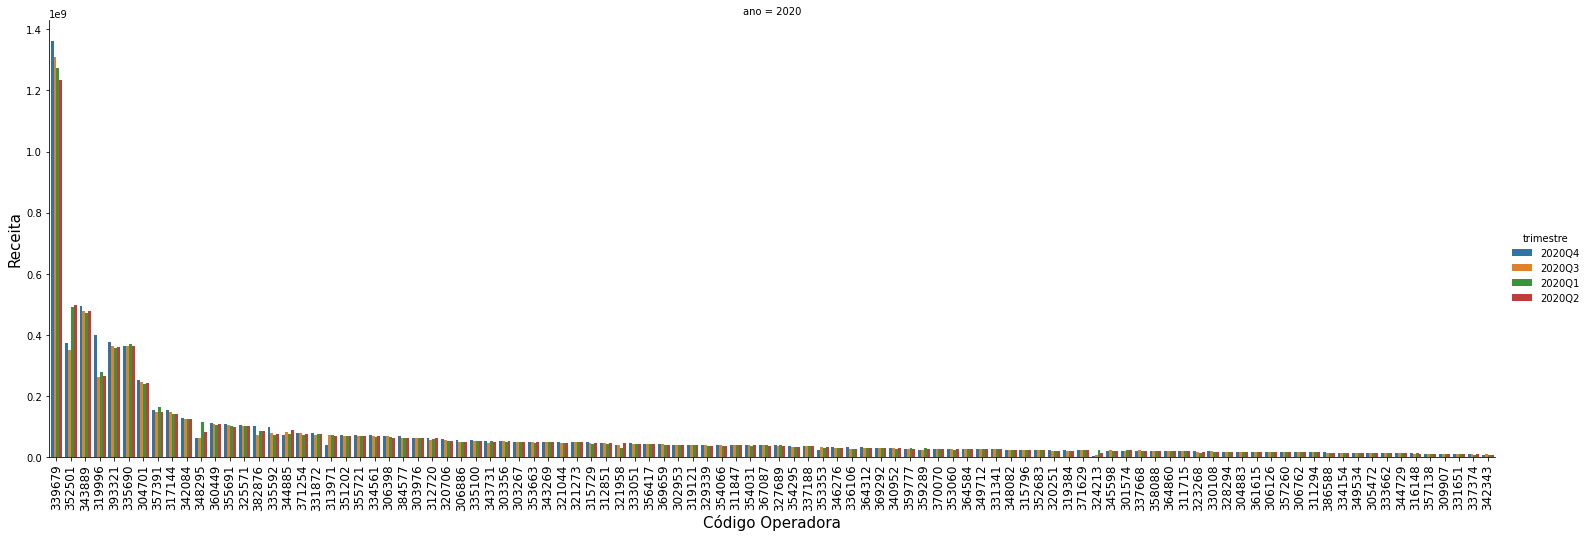

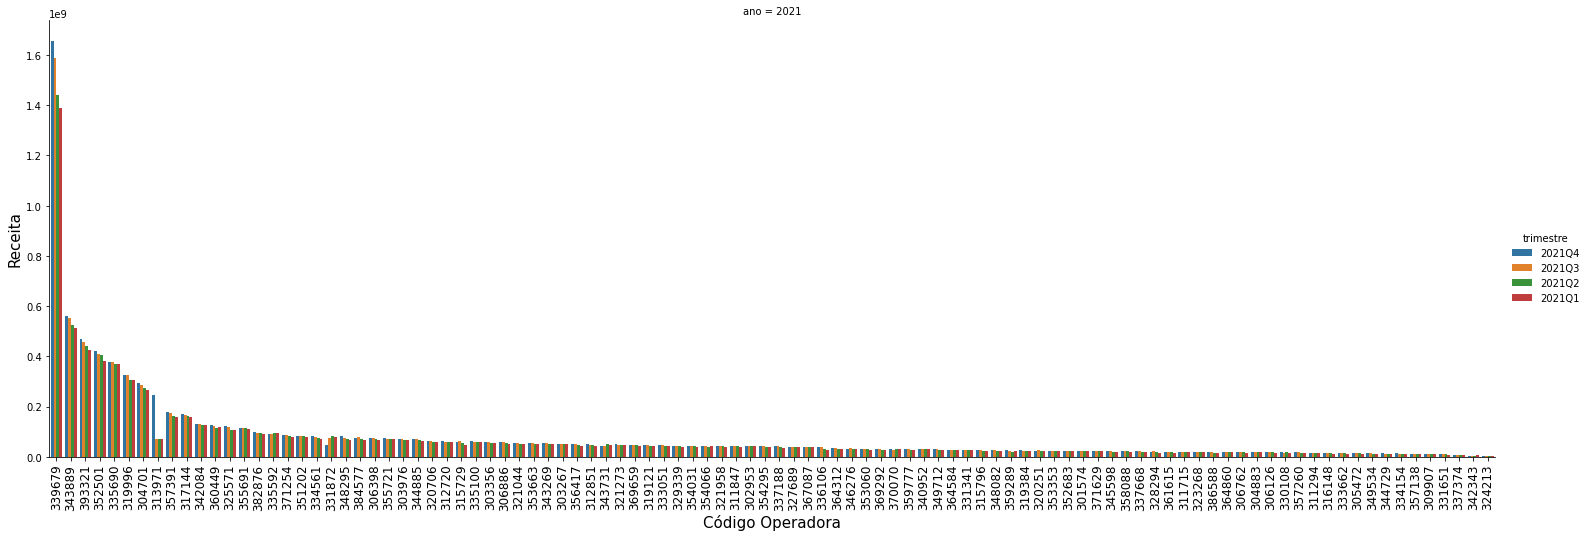

In [42]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

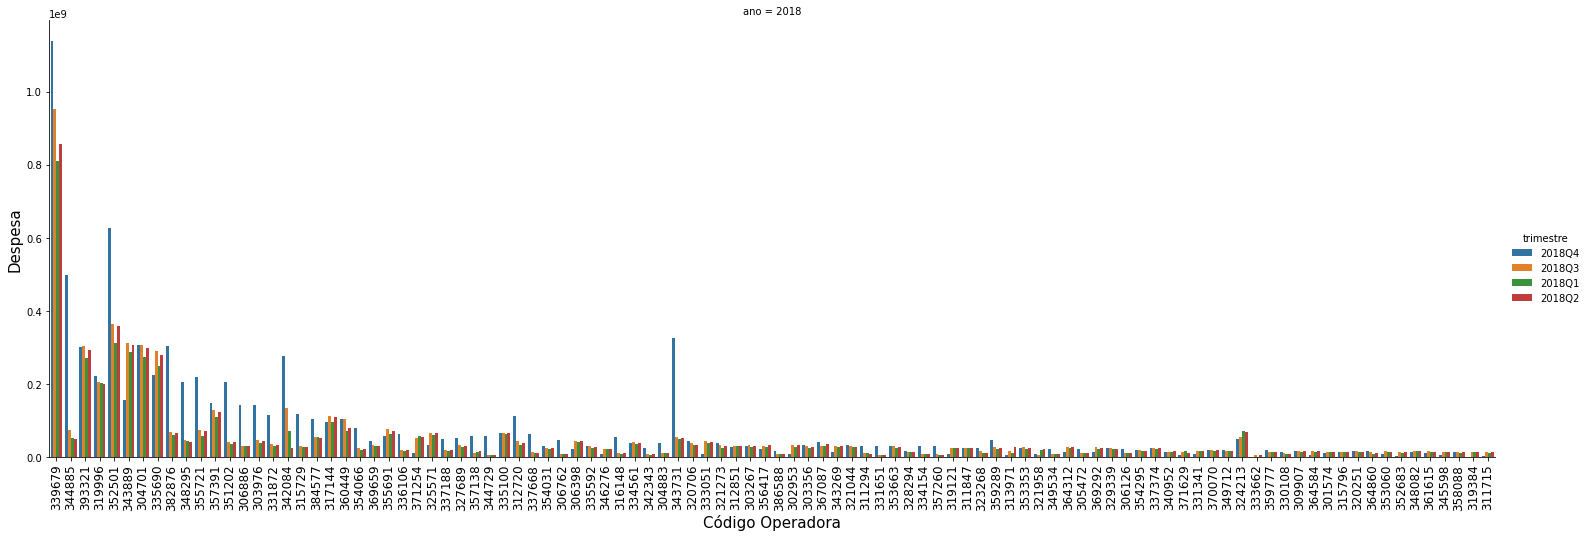

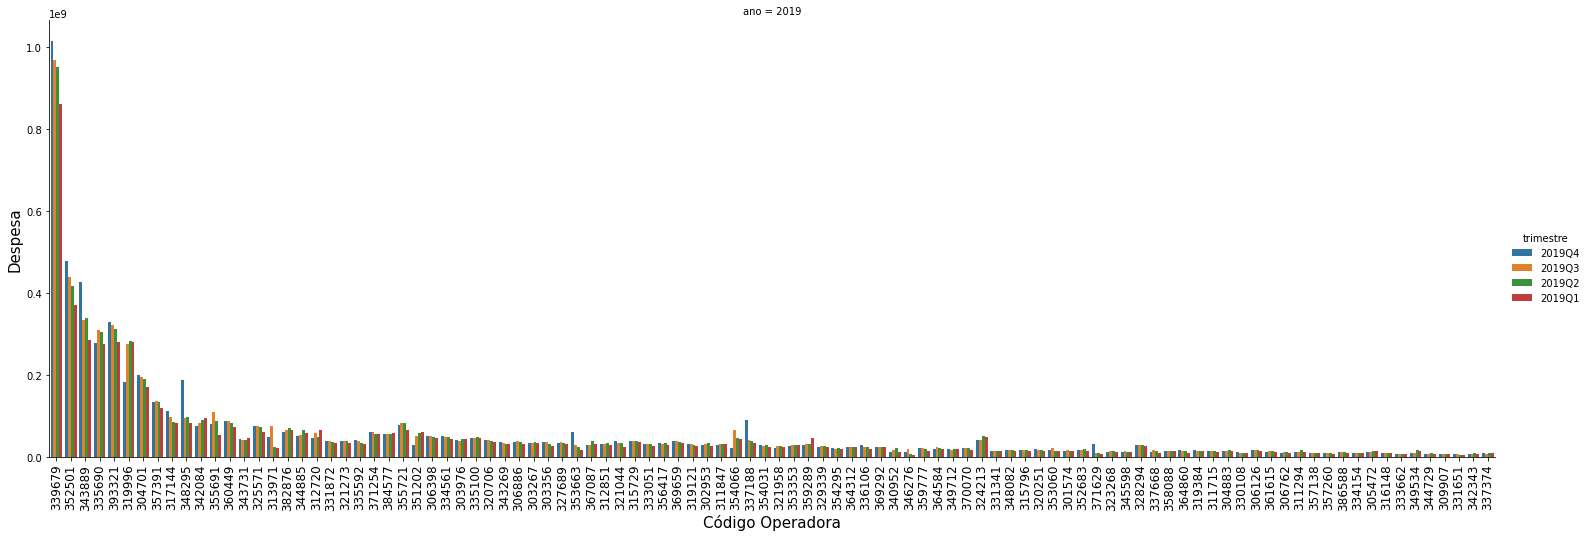

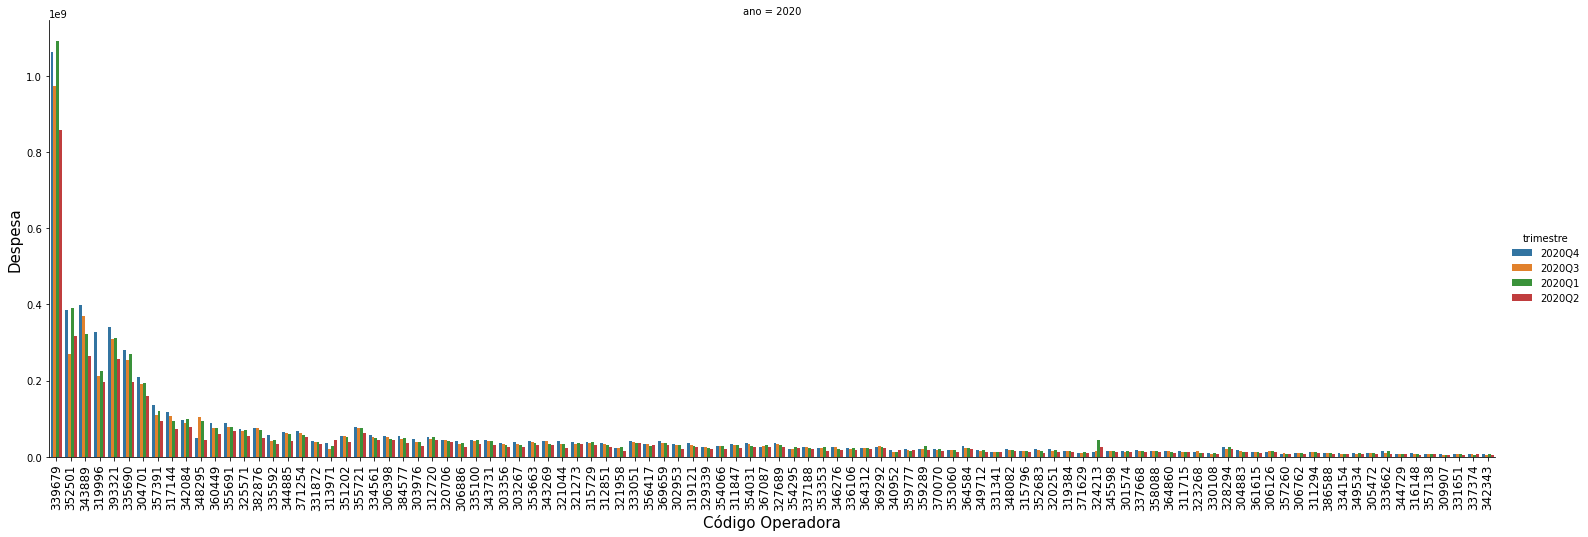

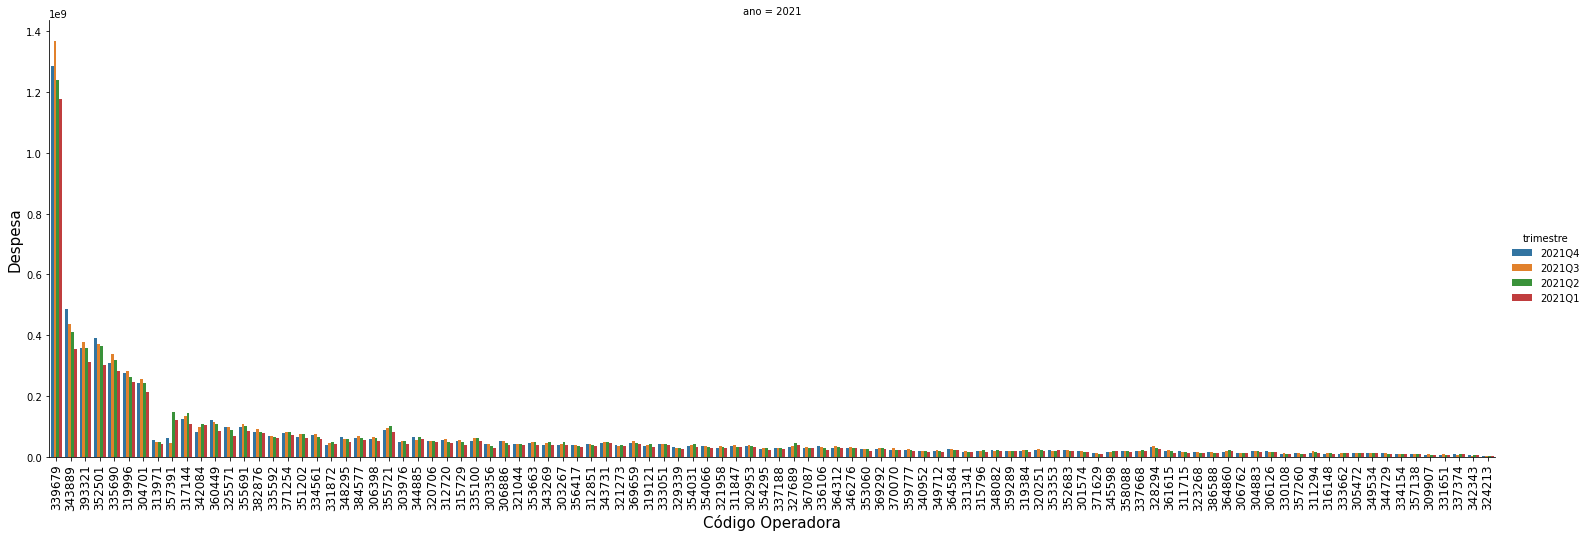

In [43]:
df_plot = ans_alterada16.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot

### 2ª Etapa

Corrigindo alguns pontos outliers que nao acompanham o crescimento médio da curva de receita e despesa

In [44]:
#Base com a quantidade de operadoras corrigida

display(ans_alterada14.info())

display(ans_alterada14.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4232 entries, 0 to 4231
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype        
---  ------     --------------  -----        
 0   ano        4232 non-null   period[A-DEC]
 1   cd_ops     4232 non-null   object       
 2   trimestre  4232 non-null   period[Q-DEC]
 3   receita    4232 non-null   float64      
 4   despesa    4232 non-null   float64      
dtypes: float64(2), object(1), period[A-DEC](1), period[Q-DEC](1)
memory usage: 165.4+ KB


None

,ano,cd_ops,trimestre,receita,despesa
0,2018,300136,2018Q1,11998036.020000,8534399.230000
1,2018,300136,2018Q2,10346163.300000,8775384.340000
2,2018,300136,2018Q3,8764161.650000,7271328.080000
3,2018,300136,2018Q4,8831205.600000,4067178.990000
4,2018,300713,2018Q1,3160036.250000,5621268.280000


In [45]:
ans_alterada16 = ans_alterada14.groupby(['ano','cd_ops'], as_index=False).agg(  receita_total = ('receita','sum'),
                                                                                despesa_total = ('despesa','sum'))

ans_alterada17 = pd.merge(ans_alterada14,ans_alterada16, how='left', on=['ano','cd_ops'])

#Escolha do ano que possui pontos fora a curva média de crescimento da receita e despesa
ans_alterada17 = ans_alterada17[(ans_alterada17['ano']=='2018')]

ans_alterada17['pct_receita'] = ans_alterada17['receita'] / ans_alterada17['receita_total']

ans_alterada17['pct_despesa'] = ans_alterada17['despesa'] / ans_alterada17['despesa_total']

ans_alterada17.head()

,ano,cd_ops,trimestre,receita,despesa,receita_total,despesa_total,pct_receita,pct_despesa
0,2018,300136,2018Q1,11998036.020000,8534399.230000,39939566.570000,28648290.640000,0.300405,0.297903
1,2018,300136,2018Q2,10346163.300000,8775384.340000,39939566.570000,28648290.640000,0.259045,0.306314
2,2018,300136,2018Q3,8764161.650000,7271328.080000,39939566.570000,28648290.640000,0.219436,0.253814
3,2018,300136,2018Q4,8831205.600000,4067178.990000,39939566.570000,28648290.640000,0.221114,0.141969
4,2018,300713,2018Q1,3160036.250000,5621268.280000,34587201.590000,21794119.210000,0.091364,0.257926


In [46]:
#calculado o valor limite dos outliers
stats_ans_alterada3 = ans_alterada17.groupby(['ano','trimestre'])[['pct_receita','pct_despesa']].describe(percentiles = [.40])

stats_ans_alterada3

pct_receita                                                       pct_despesa                                                      
                     count     mean      std      min      40%      50%      max       count     mean      std      min      40%      50%      max
ano  trimestre                                                                                                                                    
2018 2018Q1     261.000000 0.213584 0.048570 0.069428 0.229487 0.234171 0.385333  261.000000 0.222180 0.064441 0.040647 0.221147 0.230972 0.488350
     2018Q2     261.000000 0.222008 0.051875 0.055103 0.239753 0.243194 0.446634  261.000000 0.240635 0.069751 0.033172 0.242958 0.251159 0.469163
     2018Q3     261.000000 0.229441 0.051116 0.061412 0.248825 0.251671 0.434962  261.000000 0.247524 0.069349 0.035269 0.249528 0.259843 0.469401
     2018Q4     261.000000 0.334967 0.139160 0.047124 0.263759 0.266624 0.807200  261.000000 0.289661 0.181401 0.002407 0.236739 0.258025 0.890912

In [47]:
stats_ans_alterada4 = stats_ans_alterada3.reset_index(level=[0,1])

stats_ans_alterada4.columns = ['_'.join(col) for col in stats_ans_alterada4.columns.values]

stats_ans_alterada4 = stats_ans_alterada4[['ano_','trimestre_','pct_receita_mean','pct_despesa_mean','pct_receita_50%','pct_despesa_50%','pct_receita_40%', 'pct_despesa_40%']]

stats_ans_alterada4.rename(columns = {'ano_':'ano',
                                      'trimestre_':'trimestre',
                                      'pct_receita_50%':'pct_receita_50',
                                      'pct_despesa_50%':'pct_despesa_50',
                                      'pct_receita_40%':'pct_receita_ref',
                                      'pct_despesa_40%':'pct_despesa_ref'}, inplace = True)

stats_ans_alterada4

,ano,trimestre,pct_receita_mean,pct_despesa_mean,pct_receita_50,pct_despesa_50,pct_receita_ref,pct_despesa_ref
0,2018,2018Q1,0.213584,0.222180,0.234171,0.230972,0.229487,0.221147
1,2018,2018Q2,0.222008,0.240635,0.243194,0.251159,0.239753,0.242958
2,2018,2018Q3,0.229441,0.247524,0.251671,0.259843,0.248825,0.249528
3,2018,2018Q4,0.334967,0.289661,0.266624,0.258025,0.263759,0.236739


In [48]:
ans_alterada18 = pd.merge(ans_alterada17,stats_ans_alterada4[['ano','trimestre','pct_receita_mean','pct_despesa_mean','pct_receita_50','pct_despesa_50','pct_receita_ref','pct_despesa_ref']], how='left', on=['ano','trimestre'])

ans_alterada18['receita_mean'] = ans_alterada18['receita_total'] * ans_alterada18['pct_receita_50']

ans_alterada18['despesa_mean'] = ans_alterada18['despesa_total'] * ans_alterada18['pct_despesa_50']

ans_alterada18 = ans_alterada18[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise18[diops_tcc_analise18['cd_ops']=='300012']

ans_alterada18.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,300136,2018Q1,9352681.246697,6616958.220483
1,2018,300136,2018Q2,9713052.961262,7195287.985986
2,2018,300136,2018Q3,10051641.844656,7444067.729424
3,2018,300136,2018Q4,10648842.272786,7391976.704108
4,2018,300713,2018Q1,8099313.524587,5033835.284519


In [49]:
#Filtrando as operadora que possuem receita percentual ou despesa percentual acima da média do grupo
ans_alterada19 = pd.merge(ans_alterada17,stats_ans_alterada4, how='left', on=['ano','trimestre'])

ans_alterada19 = ans_alterada19[(ans_alterada19['pct_receita'] > ans_alterada19['pct_receita_50'])]

ans_alterada19 = ans_alterada19[['ano','cd_ops','trimestre','receita','despesa']]

ans_alterada19.sort_values(by=['ano'], ascending=[True], ignore_index=True, inplace=True)

ans_alterada19.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300136,2018Q1,11998036.020000,8534399.230000
1,2018,353698,2018Q1,2110620.900000,395532.200000
2,2018,353663,2018Q4,36420636.500000,30353059.590000
3,2018,353663,2018Q3,34620749.770000,28435792.760000
4,2018,353353,2018Q4,30677627.250000,24857801.110000


In [50]:
ans_alterada20 = pd.merge(ans_alterada19,ans_alterada18, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada20 = ans_alterada20[['ano','cd_ops','trimestre','receita_mean','despesa_mean']]

#diops_tcc_analise20[diops_tcc_analise20['cd_ops']=='300012']

ans_alterada20.head()

,ano,cd_ops,trimestre,receita_mean,despesa_mean
0,2018,300136,2018Q1,9352681.246697,6616958.220483
1,2018,353698,2018Q1,2021478.165309,524216.891122
2,2018,353663,2018Q4,36134885.531256,28115314.137765
3,2018,353663,2018Q3,34108395.838113,28313441.864509
4,2018,353353,2018Q4,30183709.216511,24603251.234789


In [51]:
ans_alterada21 = pd.merge(ans_alterada14,ans_alterada20, how='left', on=['ano','cd_ops','trimestre'])

#diops_tcc_analise21['receita_diff'] = (diops_tcc_analise21['receita'] - diops_tcc_analise21['receita_mean']) / 4.0

#diops_tcc_analise21['despesa_diff'] = (diops_tcc_analise21['despesa'] - diops_tcc_analise21['despesa_mean'])/ 4.0

ans_alterada21.fillna(0, inplace=True)

ans_alterada21['receita_corrigida'] = np.where(ans_alterada21['receita_mean'] == 0, ans_alterada21['receita'], ans_alterada21['receita_mean'])

ans_alterada21['despesa_corrigida'] = np.where(ans_alterada21['despesa_mean'] == 0, ans_alterada21['despesa'], ans_alterada21['despesa_mean'])

ans_alterada21['receita_diff_tri'] = (ans_alterada21['receita'] - ans_alterada21['receita_corrigida']) / 4.0

ans_alterada21['despesa_diff_tri'] = (ans_alterada21['despesa'] - ans_alterada21['despesa_corrigida']) / 4.0

#diops_tcc_analise21[diops_tcc_analise21['trimestre']=='2018Q4']

ans_alterada21.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada21.head()

,ano,cd_ops,trimestre,receita,despesa,receita_mean,despesa_mean,receita_corrigida,despesa_corrigida,receita_diff_tri,despesa_diff_tri
0,2018,300136,2018Q1,11998036.020000,8534399.230000,9352681.246697,6616958.220483,9352681.246697,6616958.220483,661338.693326,479360.252379
688,2018,352861,2018Q1,1474418.840000,968576.570000,1402902.951455,793666.852184,1402902.951455,793666.852184,17878.972136,43727.429454
689,2018,352861,2018Q2,1547667.610000,1157558.780000,1456958.738095,863034.248685,1456958.738095,863034.248685,22677.217976,73631.132829
690,2018,352861,2018Q3,1497103.240000,1183036.840000,0.000000,0.000000,1497103.240000,1183036.840000,0.000000,0.000000
691,2018,352861,2018Q4,1471748.560000,127028.840000,0.000000,0.000000,1471748.560000,127028.840000,0.000000,0.000000


In [52]:
ans_alterada22 = ans_alterada21.groupby(['ano','cd_ops'], as_index=False)[['receita_diff_tri','despesa_diff_tri']].sum()

ans_alterada22 = ans_alterada22[ans_alterada22['receita_diff_tri']!=0]

ans_alterada22.head()

,ano,cd_ops,receita_diff_tri,despesa_diff_tri
0,2018,300136,819616.278010,874384.340883
1,2018,300713,1294159.330022,509492.360930
2,2018,301060,2017274.018244,-819521.465946
3,2018,301124,53560.836635,24274.101223
4,2018,301574,217692.036018,670622.343152


In [53]:
ans_alterada23 = ans_alterada21[['ano','cd_ops','trimestre','receita_corrigida','despesa_corrigida']].reset_index(drop=True)

ans_alterada23.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada23.head()

,ano,cd_ops,trimestre,receita_corrigida,despesa_corrigida
0,2018,300136,2018Q1,9352681.246697,6616958.220483
688,2018,300136,2018Q3,8764161.650000,7271328.080000
689,2018,300136,2018Q4,8831205.600000,4067178.990000
690,2018,300713,2018Q1,3160036.250000,5621268.280000
691,2018,300713,2018Q2,8411391.251247,5473798.283026


In [54]:
ans_alterada24 = pd.merge(ans_alterada23, ans_alterada22, how='left', on = ['ano','cd_ops'])

ans_alterada24.fillna(0, inplace=True)

ans_alterada24.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada24['receita'] = ans_alterada24['receita_corrigida'] + ans_alterada24['receita_diff_tri']

ans_alterada24['despesa'] = ans_alterada24['despesa_corrigida'] + ans_alterada24['despesa_diff_tri']

ans_alterada24 = ans_alterada24[['ano','cd_ops','trimestre','receita','despesa']]

#ans_alterada24[ans_alterada24['cd_ops']=='342084']

ans_alterada24.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300136,2018Q1,10172297.524708,7491342.561366
688,2018,352861,2018Q2,1497514.928208,980392.810968
689,2018,352861,2018Q3,1537659.430112,1300395.402283
690,2018,352861,2018Q4,1512304.750112,244387.402283
691,2018,353027,2018Q1,6709361.350866,4866685.116967


In [55]:
ans_alterada24 = pd.merge(ans_alterada23, ans_alterada22, how='left', on = ['ano','cd_ops'])

ans_alterada24.fillna(0, inplace=True)

ans_alterada24.sort_values(by=['ano'], ignore_index=False, inplace=True)

ans_alterada24['receita'] = ans_alterada24['receita_corrigida'] + ans_alterada24['receita_diff_tri']

ans_alterada24['despesa'] = ans_alterada24['despesa_corrigida'] + ans_alterada24['despesa_diff_tri']

ans_alterada24 = ans_alterada24[['ano','cd_ops','trimestre','receita','despesa']]

#ans_alterada24[ans_alterada24['cd_ops']=='342084']

ans_alterada24.head()

,ano,cd_ops,trimestre,receita,despesa
0,2018,300136,2018Q1,10172297.524708,7491342.561366
688,2018,352861,2018Q2,1497514.928208,980392.810968
689,2018,352861,2018Q3,1537659.430112,1300395.402283
690,2018,352861,2018Q4,1512304.750112,244387.402283
691,2018,353027,2018Q1,6709361.350866,4866685.116967


In [56]:
ans_alterada25 = ans_alterada24.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada25['pct_despesa'] = ans_alterada25.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada25.columns = ['ano', 'trimestre', 'receita', 'despesa', 'n_ops', 'pct_despesa']

ans_alterada25 = ans_alterada25[['trimestre','receita','despesa','n_ops','pct_despesa']]

ans_alterada25.set_index('trimestre', inplace=True)

ans_alterada25

,receita,despesa,n_ops,pct_despesa
trimestre,,,,
2018Q1,7.760000,5.860000,261,75.520000
2018Q2,7.880000,6.240000,261,79.190000
2018Q3,8.230000,6.610000,261,80.320000
2018Q4,9.660000,7.420000,261,76.810000
2019Q1,7.380000,5.830000,265,79.000000
2019Q2,7.640000,6.440000,265,84.290000
2019Q3,7.860000,6.600000,265,83.970000
2019Q4,7.980000,6.750000,265,84.590000
2020Q1,8.110000,6.330000,266,78.050000


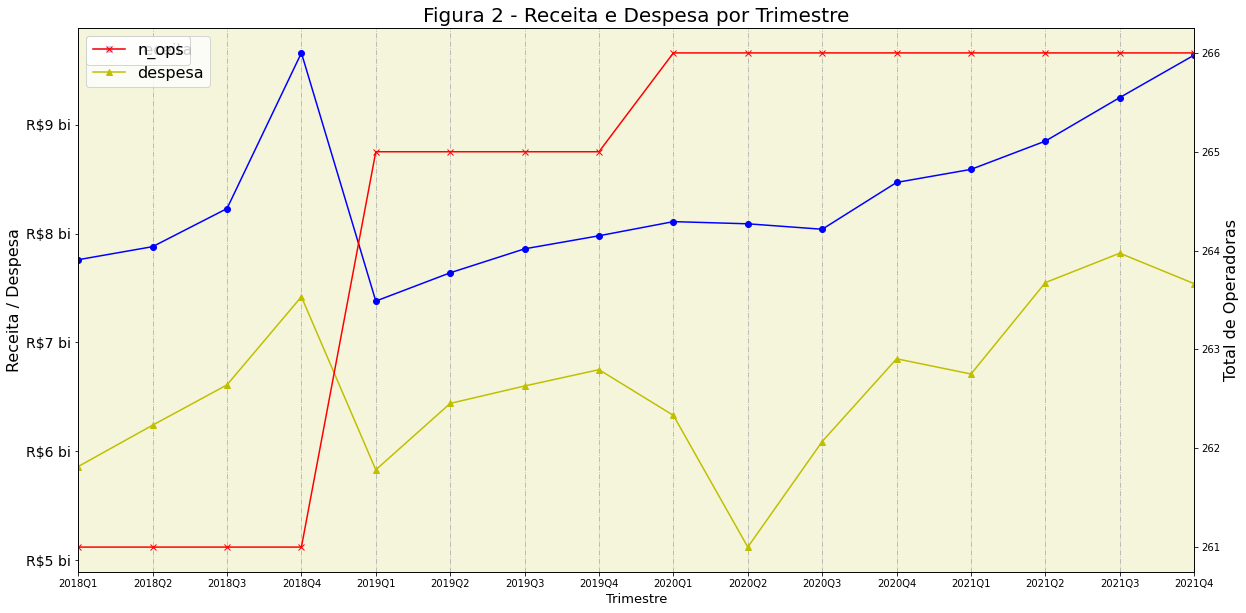

In [57]:
df_plot = ans_alterada25.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 2 - Receita e Despesa por Trimestre',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita / Despesa', fontsize=16)
ax1.legend(loc = 'best', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'best', fontsize = 16)

plt.savefig('emp_coopmed_01.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()
del df_plot

### Merge com a base de beneficiarios

In [59]:
###############################################################################################################################################################################################
#                                                                              SIB -   BENEFICIARIOS
###############################################################################################################################################################################################

#Caminho da pasta com as bases de dados beneficiarios
path_beneficiario = r'D:\TCC\tcc-main\Beneficiarios\Beneficiarios_operadora_e_carteira.csv'

sib = pd.read_csv(path_beneficiario, sep=';', encoding='utf-8')

sib.columns = ['cd_operadora', 'razao_social', 'gr_modalidade', 'vigencia_plano', 'gr_contratacao', 'tipo_financiamento', 'mes', 'id_cmpt', 'nr_benef']

sib['mes']= pd.to_datetime(sib['mes'], format='%Y%m', errors='coerce').dropna()

sib.columns = ['cd_ops', 'razao_social', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'id_cmpt', 'benef']

sib.loc[(sib.contratacao == 'Coletivo empresarial'),'contratacao'] = 'Empresarial'
sib.loc[(sib.contratacao == 'Coletivo por adesão'),'contratacao'] = 'Adesao'
sib.loc[(sib.contratacao == 'Individual ou familiar'),'contratacao'] = 'Individual'

sib = sib.loc[(sib['id_calendar'] >= Periodo[0]) & (sib['id_calendar'] <= Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'benef']]

sib['ano'] = sib['id_calendar'].dt.year

sib['trimestre'] = sib['id_calendar'].dt.to_period('Q')

sib = sib[['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

sib.sort_values(by=['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre'], inplace=True)

sib

,cd_ops,modalidade,vigencia,contratacao,financiamento,id_calendar,ano,trimestre,benef
146900,27,Médico-hospitalar,A,Individual,Não identificado,2017-09-01,2017,2017Q3,4
228965,27,Médico-hospitalar,A,Individual,Não identificado,2017-10-01,2017,2017Q4,4
332456,27,Médico-hospitalar,A,Individual,Não identificado,2017-11-01,2017,2017Q4,4
332180,27,Médico-hospitalar,A,Individual,Não identificado,2017-12-01,2017,2017Q4,4
33924,27,Médico-hospitalar,A,Individual,Não identificado,2018-01-01,2018,2018Q1,4
...,...,...,...,...,...,...,...,...,...
390516,422975,Odontológico,P,Adesao,Pre-estabelecido,2022-03-01,2022,2022Q1,137
137641,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-01-01,2022,2022Q1,92
250037,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-02-01,2022,2022Q1,99
29707,422975,Odontológico,P,Empresarial,Pre-estabelecido,2022-03-01,2022,2022Q1,115


In [60]:
# Segmenta porte da operadora pela quantidade de beneficiários médico-hospitalares

ops = sib.loc[(sib['id_calendar'] == Periodo[1]), ['cd_ops', 'modalidade', 'vigencia', 'contratacao', 'financiamento', 'id_calendar', 'ano', 'trimestre', 'benef']]

ops = ops.groupby(['cd_ops'], as_index=False)['benef'].agg('sum')

ops.loc[(ops.benef > 100000),'port_ops'] = 'Grande'
ops.loc[((ops.benef <= 100000) & (ops.benef >= 20000)  ),'port_ops'] = 'Médio'
ops.loc[(ops.benef < 20000),'port_ops'] = 'Pequeno'

ops.head()

,cd_ops,benef,port_ops
0,477,115244,Grande
1,515,33402,Médio
2,582,990798,Grande
3,701,614431,Grande
4,884,8336,Pequeno


In [61]:
filtro1 = sib['modalidade'].isin(['Médico-hospitalar'])
filtro2 = sib['financiamento'] != 'Não identificado'
filtro3 = sib['contratacao'].isin(['Empresarial', 'Individual', 'Adesao'])

sib_filtrada = sib.loc[filtro1 & filtro2 & filtro3]

sib_filtrada = sib_filtrada.groupby(['ano','cd_ops','vigencia','contratacao', 'financiamento', 'id_calendar', 'trimestre'], as_index=False)['benef'].agg('sum')

sib_filtrada.replace('Pós-estabelecido','Pos-estabelecido', inplace=True)

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7
106447,2022,422835,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,14


In [62]:
#################################################################################################################################################################################
#Calcula média de beneficiários acumulada no ano por operadora e tipo de contratação:

sib_filtrada = sib_filtrada.sort_values(['ano','cd_ops','contratacao','id_calendar','trimestre','benef'], ascending=[True, True, True, True, True, False])

sib_filtrada['mes'] = sib_filtrada['id_calendar'].dt.month 

sib_filtrada['benefm'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].apply(lambda x: x.expanding().mean()))

sib_filtrada['n_meses'] = (sib_filtrada.groupby(['cd_ops','contratacao', 'ano', 'trimestre'], sort=False)['benef'].transform('size'))

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef', 'benefm', 'n_meses', 'mes']]

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef,benefm,n_meses,mes
0,2017,27,P,Adesao,Pre-estabelecido,2017-09-01,2017Q3,11173,11173.000000,1,9
1,2017,27,P,Adesao,Pre-estabelecido,2017-10-01,2017Q4,10909,10909.000000,3,10
2,2017,27,P,Adesao,Pre-estabelecido,2017-11-01,2017Q4,10754,10831.500000,3,11
3,2017,27,P,Adesao,Pre-estabelecido,2017-12-01,2017Q4,10584,10749.000000,3,12
4,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237,17237.000000,1,9
...,...,...,...,...,...,...,...,...,...,...,...
106444,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188,143.000000,2,3
106445,2022,422835,P,Empresarial,Pre-estabelecido,2022-01-01,2022Q1,3,3.000000,4,1
106446,2022,422835,P,Empresarial,Pre-estabelecido,2022-02-01,2022Q1,7,5.000000,4,2
106448,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646,218.666667,4,3


In [63]:
sib_filtrada = sib_filtrada.loc[sib_filtrada['mes'].isin([3,6,9,12])]

sib_filtrada.drop(['mes','benefm','n_meses'], axis='columns', inplace=True)

sib_filtrada = sib_filtrada[['ano','cd_ops','vigencia','contratacao','financiamento','id_calendar','trimestre','benef']]

sib_filtrada['ano'] =  pd.to_datetime(sib_filtrada['ano'], format='%Y')

sib_filtrada['ano'] = sib_filtrada['ano'].dt.to_period('Y')

sib_filtrada['cd_ops'] = sib_filtrada['cd_ops'].astype('str')

sib_filtrada = sib_filtrada[(sib_filtrada['contratacao'] == tipo_contratacao)].reset_index(drop=True)

sib_filtrada

,ano,cd_ops,vigencia,contratacao,financiamento,id_calendar,trimestre,benef
0,2017,27,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,17237
1,2017,27,P,Empresarial,Pre-estabelecido,2017-12-01,2017Q4,17190
2,2017,477,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,115620
3,2017,477,P,Empresarial,Pre-estabelecido,2017-12-01,2017Q4,106010
4,2017,515,P,Empresarial,Pre-estabelecido,2017-09-01,2017Q3,69520
...,...,...,...,...,...,...,...,...
15298,2022,422762,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,50
15299,2022,422771,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,91
15300,2022,422827,P,Empresarial,Pre-estabelecido,2022-03-01,2022Q1,188
15301,2022,422835,P,Empresarial,Pos-estabelecido,2022-03-01,2022Q1,646


In [64]:
ans_alterada25 = pd.merge(ans_alterada24,sib_filtrada, how='left', on=['ano','cd_ops','trimestre'])

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25['modalidade'] = tipo_modalidade

ans_alterada25['contratacao'] = tipo_contratacao

ans_alterada25.to_csv('emp_coopmed.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada25 = ans_alterada25[['ano','cd_ops','trimestre','receita','despesa','benef']]

ans_alterada25.head()

,ano,cd_ops,trimestre,receita,despesa,benef
0,2018,300136,2018Q1,10172297.524708,7491342.561366,18700
1,2018,300136,2018Q1,10172297.524708,7491342.561366,4552
2,2018,352861,2018Q2,1497514.928208,980392.810968,3900
3,2018,352861,2018Q3,1537659.430112,1300395.402283,3773
4,2018,352861,2018Q4,1512304.750112,244387.402283,3745


In [65]:
ans_alterada26 = ans_alterada25.groupby(['ano','trimestre'], as_index=False).agg({  'receita':lambda x: sum_billion(x),
                                                                                    'despesa':lambda x: sum_billion(x),
                                                                                    'benef': 'sum',
                                                                                    'cd_ops':lambda x: x.nunique()})

ans_alterada26['pct_despesa'] = ans_alterada26.apply(lambda x: (x['despesa']/x['receita'])*100 , axis = 1).round(2)

ans_alterada26.columns = ['ano','trimestre','receita','despesa','benef','n_ops','pct_despesa']

ans_alterada26 = ans_alterada26[['trimestre','receita','despesa','benef','n_ops','pct_despesa']]

ans_alterada26.to_csv('emp_coopmed_resumo.csv', sep=';', index=False, encoding='mbcs', decimal=',')

ans_alterada26.set_index('trimestre', inplace=True)


display(ans_alterada26.info()) 
display(ans_alterada26) 

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 16 entries, 2018Q1 to 2021Q4
Freq: Q-DEC
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   receita      16 non-null     float64
 1   despesa      16 non-null     float64
 2   benef        16 non-null     int64  
 3   n_ops        16 non-null     int64  
 4   pct_despesa  16 non-null     float64
dtypes: float64(3), int64(2)
memory usage: 768.0 bytes


None

,receita,despesa,benef,n_ops,pct_despesa
trimestre,,,,,
2018Q1,14.170000,10.740000,9536677,261,75.790000
2018Q2,14.340000,11.430000,9656945,261,79.710000
2018Q3,14.980000,12.090000,9737031,261,80.710000
2018Q4,17.780000,13.950000,9703270,261,78.460000
2019Q1,13.270000,10.590000,9705986,265,79.800000
2019Q2,13.740000,11.650000,9766476,265,84.790000
2019Q3,14.150000,11.940000,9788601,265,84.380000
2019Q4,14.350000,12.210000,9829481,265,85.090000
2020Q1,14.590000,11.440000,9908616,266,78.410000


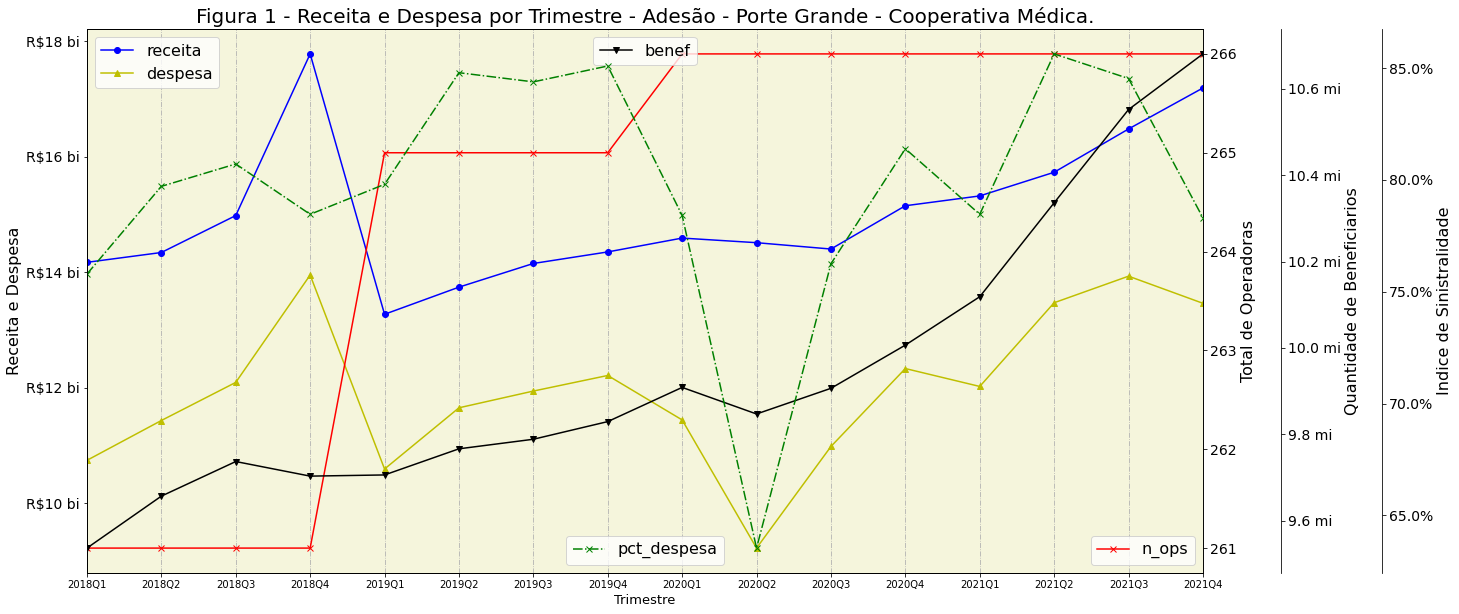

In [67]:
df_plot = ans_alterada26.copy()

fig,ax1 = plt.subplots()

df_plot.plot(y=['receita','despesa'],figsize=(20, 10), style=['bo-','y^-'], ax=ax1)
ax1.set_title('Figura 1 - Receita e Despesa por Trimestre - Adesão - Porte Grande - Cooperativa Médica.',fontsize = 20)
ax1.set_xticks(df_plot.index)
ax1.set_xticklabels(df_plot.index)
ax1.set_xlabel('Trimestre', fontsize = 13)
yticks = ax1.get_yticks()
ax1.set_yticklabels(['R${:.0f} bi'.format(x) for x in yticks], fontsize = 14)
ax1.set_ylabel('Receita e Despesa', fontsize=16)
ax1.legend(loc = 'upper left', fontsize = 16)
ax1.set_facecolor("beige")
ax1.grid(linestyle='-.', axis='x')

ax2 = ax1.twinx()

df_plot.plot(y=['n_ops'], figsize=(20,10), style=['rx-'], ax=ax2)
ax2.set_xticks(df_plot.index)
ax2.set_xticklabels(df_plot.index)
ax2.set_xlabel('Trimestre', fontsize = 13)
yticks = ax2.get_yticks()
ax2.set_yticklabels(yticks.astype(int), fontsize = 14)
ax2.set_ylabel('Total de Operadoras', fontsize=16)
ax2.legend(loc = 'lower right', fontsize = 16)

ax3 = ax1.twinx()

ax3.spines.right.set_position(("axes", 1.07))

df_plot.plot(y=['benef'], figsize=(20,10), style=['kv-'], ax=ax3)
ax3.set_xticks(df_plot.index)
ax3.set_xticklabels(df_plot.index)
ax3.set_xlabel('Trimestre', fontsize = 13)
yticks = ax3.get_yticks()
ax3.set_yticklabels(['{:.1f} mi'.format(x/1e6) for x in yticks], fontsize = 14)
ax3.set_ylabel('Quantidade de Beneficiarios', fontsize=16)
ax3.legend(loc = 'upper center', fontsize = 16)

ax4 = ax1.twinx()

ax4.spines.right.set_position(("axes", 1.16))

df_plot.plot(y=['pct_despesa'], figsize=(20,10), style=['gx-.'], ax=ax4)
ax4.set_xticks(df_plot.index)
ax4.set_xticklabels(df_plot.index)
ax4.set_xlabel('Trimestre', fontsize = 13)
yticks = ax4.get_yticks()
ax4.set_yticklabels(['{:.1f}%'.format(x) for x in yticks], fontsize = 14)
ax4.set_ylabel('Indice de Sinistralidade', fontsize=16)
ax4.legend(loc = 'lower center', fontsize = 16)

plt.savefig('ade_coopmed_02.png',
 bbox_inches="tight",
 pad_inches=1,
 facecolor='w')

plt.show()

del df_plot

In [68]:
#Cria o rankin das operadoras com maior receita e despesa
ans_alterada27 = ans_alterada25.groupby(['ano','cd_ops'], as_index=False).agg({ 'receita':lambda x: sum_million(x),
                                                                                'despesa':lambda x: sum_million(x)})

ans_alterada27.sort_values(by=['ano','receita'], ascending=[True,False], inplace=True)

ans_alterada27.head()

,ano,cd_ops,receita,despesa
135,2018,339679,9607.730000,7510.080000
256,2018,393321,3381.580000,2332.380000
148,2018,343889,3253.780000,2123.620000
177,2018,352501,3241.210000,3318.740000
18,2018,304701,3047.650000,2363.110000


In [69]:
ans_alterada_ops = ans_alterada27.head(100)

ans_alterada_ops = ans_alterada_ops[['cd_ops']].reset_index(drop=True)

keys = list(ans_alterada_ops.columns.values)
i1 = ans_alterada25.set_index(keys).index
i2 = ans_alterada_ops.set_index(keys).index

ans_alterada28 =  ans_alterada25[i1.isin(i2)]

ans_alterada28.sort_values(by=['receita'], ascending=False, inplace=True)

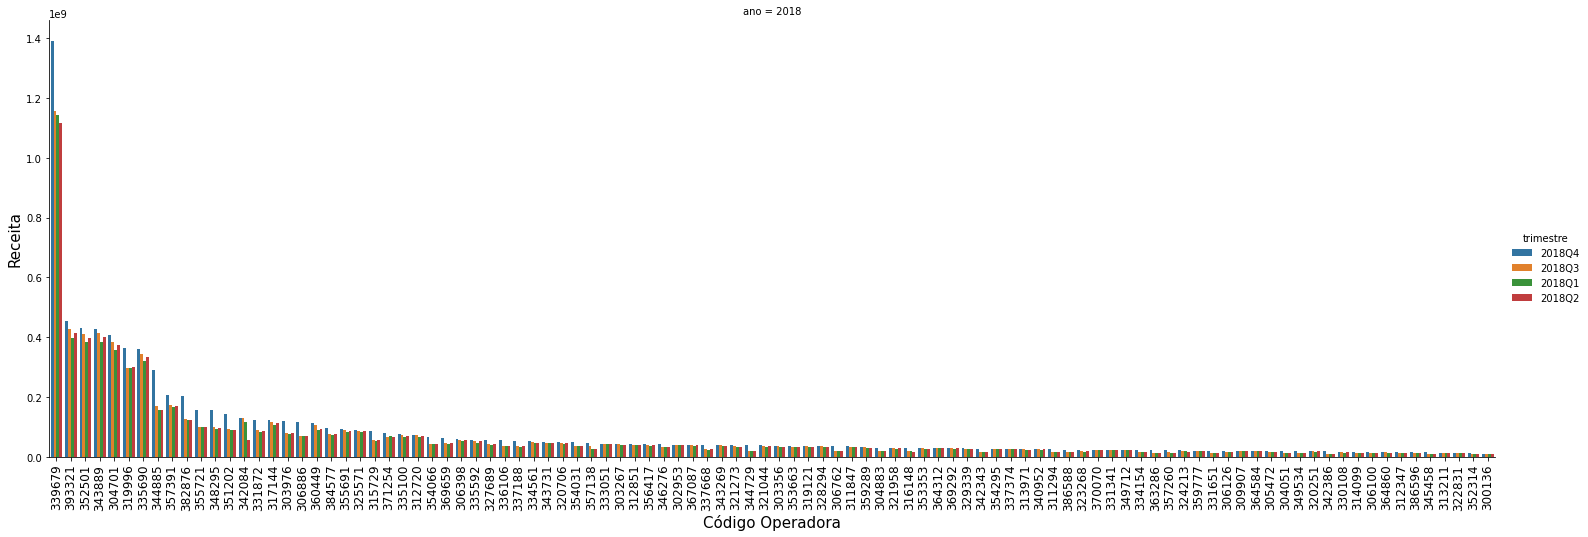

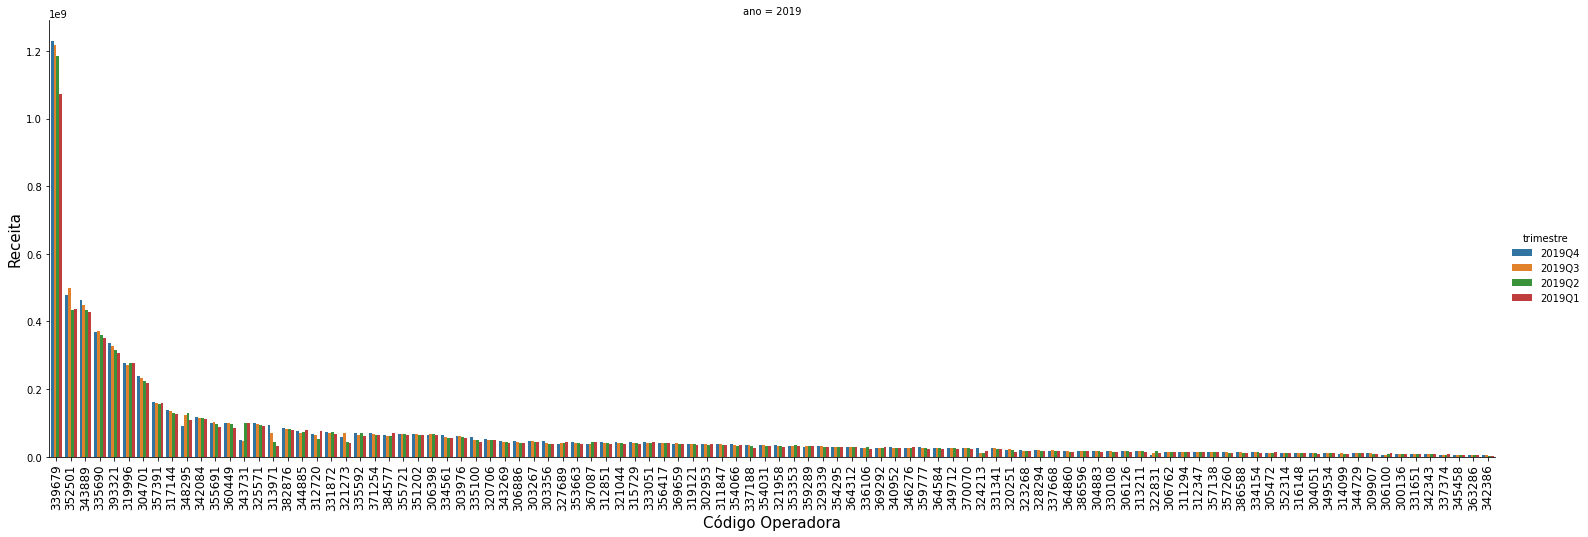

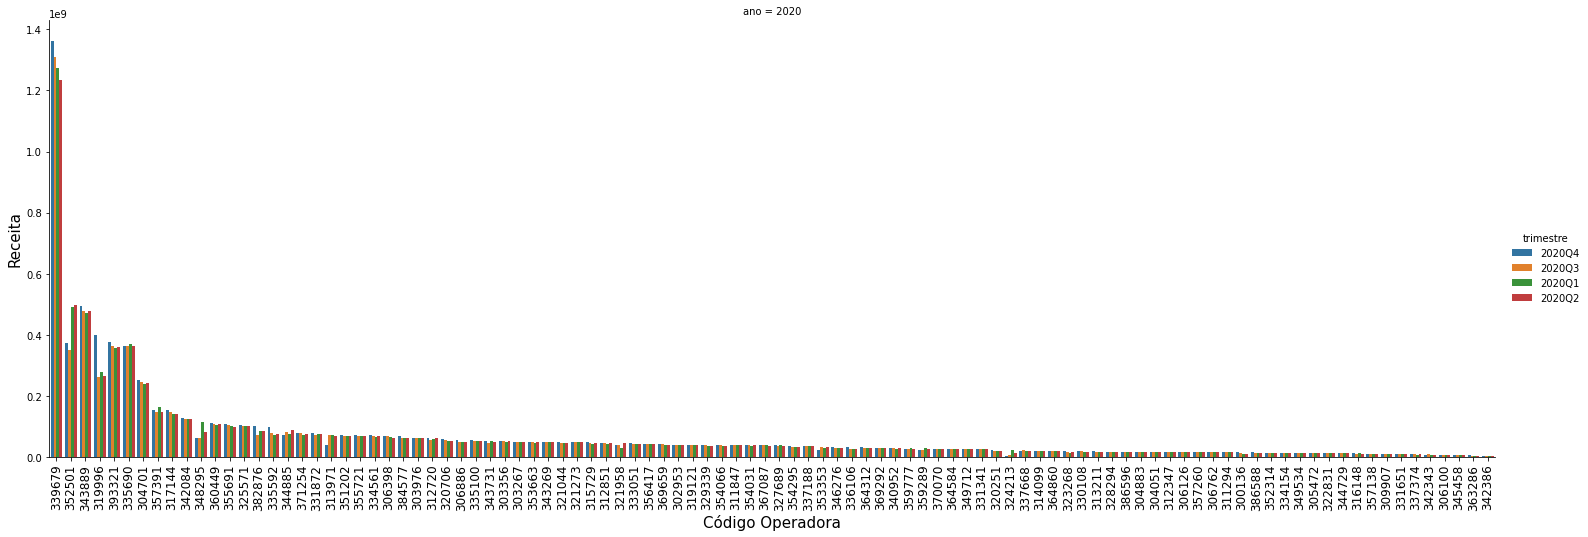

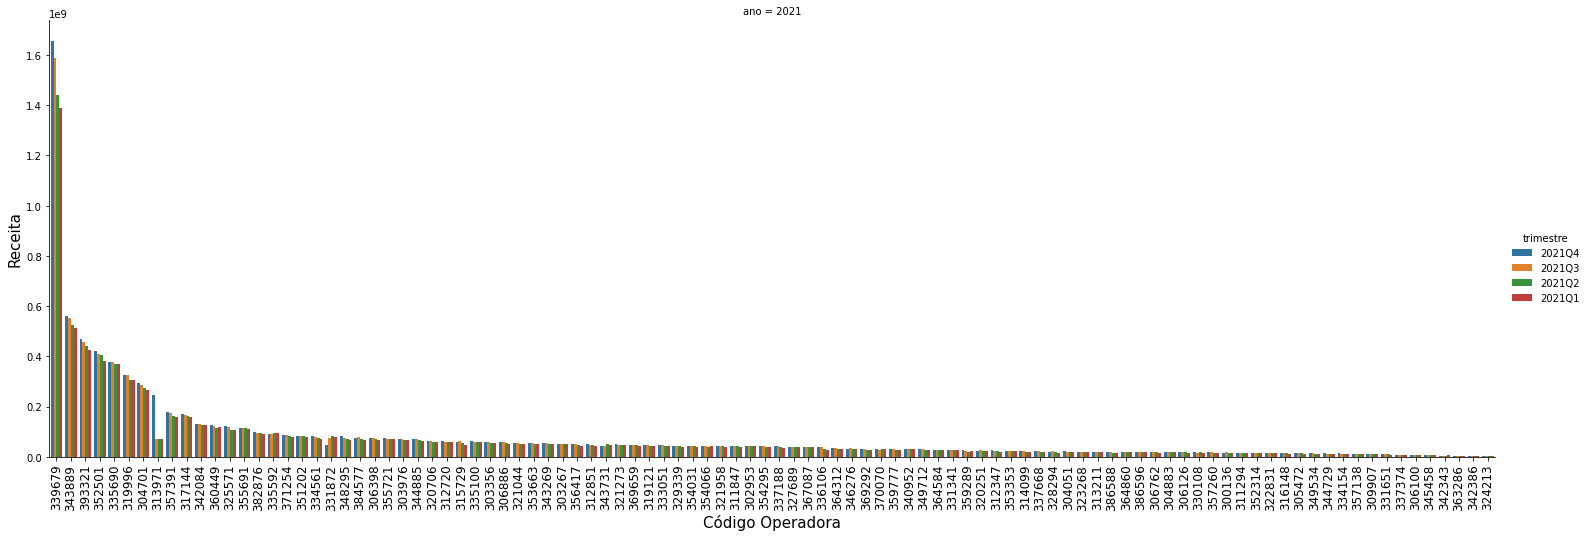

In [70]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='receita', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Receita', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Receita', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Receita', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Receita', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

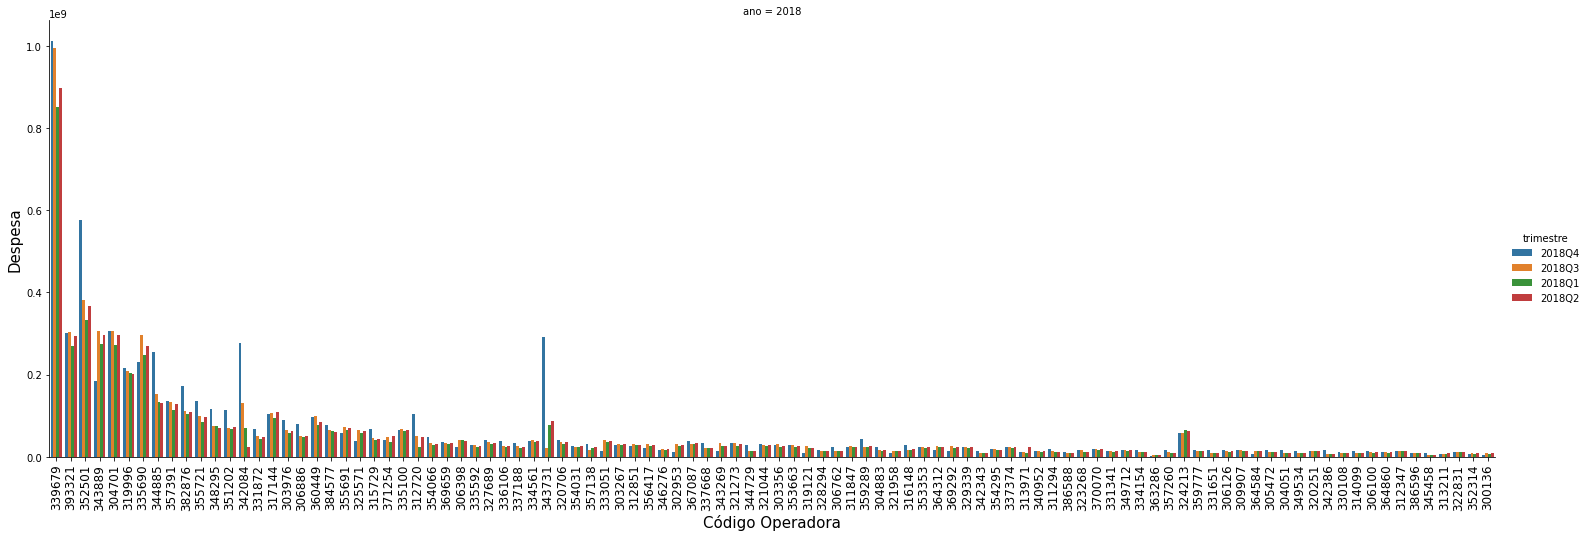

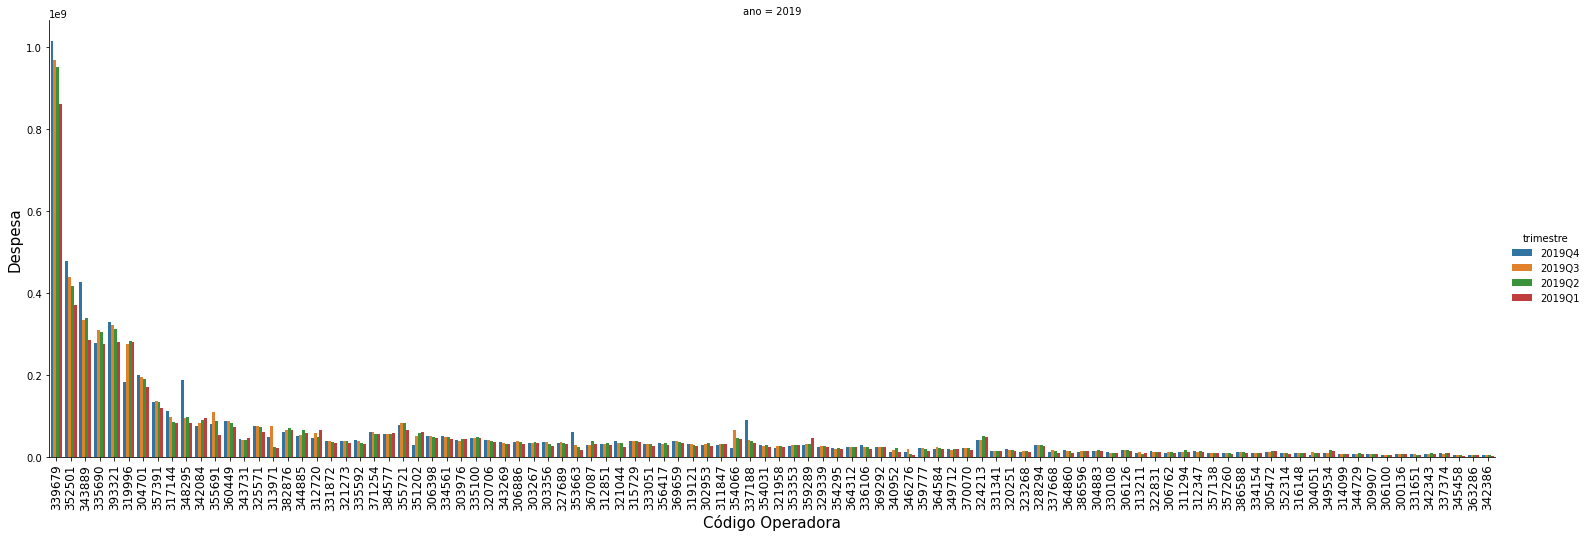

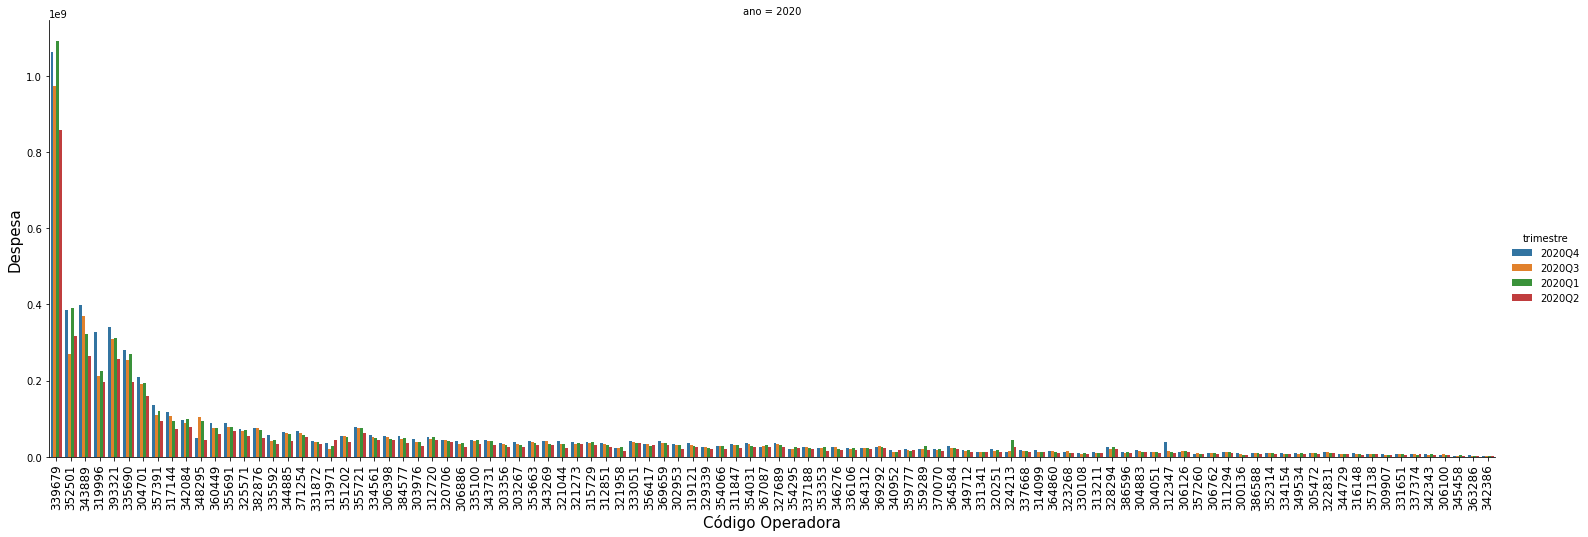

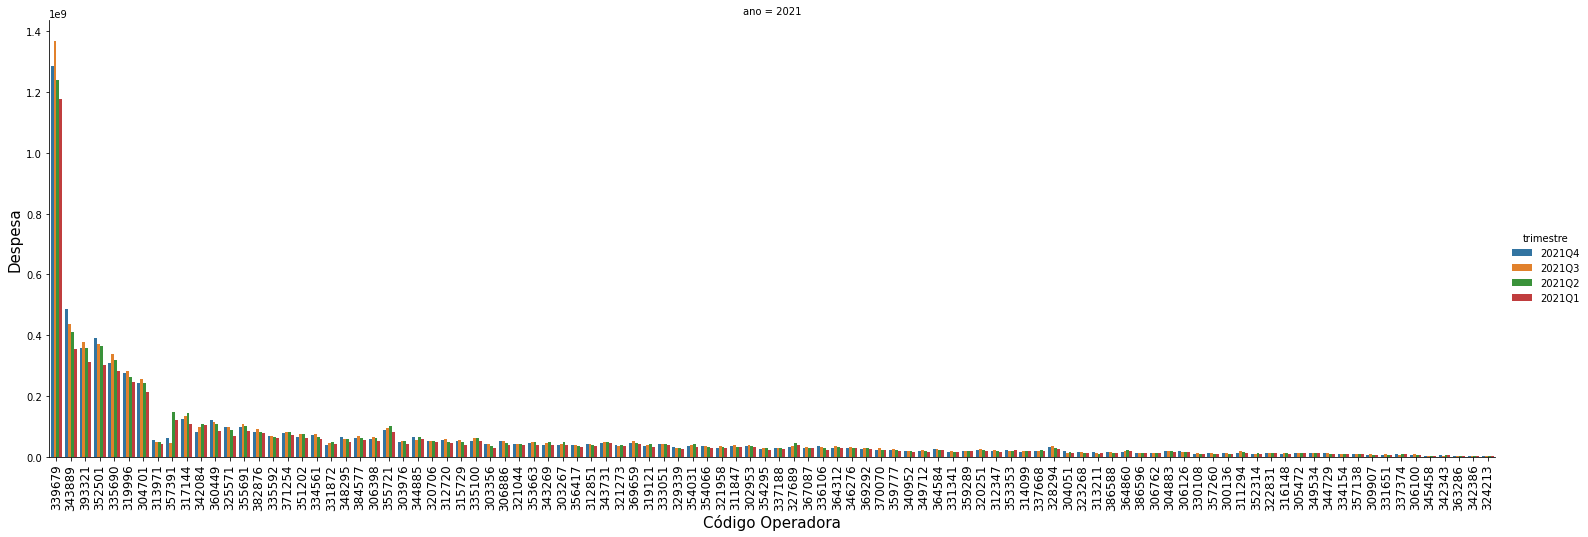

In [71]:
df_plot = ans_alterada28.copy()

fig, ax = plt.subplots(4)

ax[0] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2018'], kind='bar', col='ano', height=7, aspect=3)

ax[1] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2019'], kind='bar', col='ano', height=7, aspect=3)

ax[2] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2020'], kind='bar', col='ano', height=7, aspect=3)

ax[3] = sns.catplot(x='cd_ops', y='despesa', hue='trimestre', data = df_plot[df_plot['ano'] == '2021'], kind='bar', col='ano', height=7, aspect=3)

ax[0].set_xticklabels(rotation = 90, fontsize= 12)
ax[0].set_xlabels('Código Operadora', fontsize=15)
ax[0].set_ylabels('Despesa', fontsize= 15)

ax[1].set_xticklabels(rotation = 90, fontsize= 12)
ax[1].set_xlabels('Código Operadora', fontsize=15)
ax[1].set_ylabels('Despesa', fontsize= 15)

ax[2].set_xticklabels(rotation = 90, fontsize= 12)
ax[2].set_xlabels('Código Operadora', fontsize=15)
ax[2].set_ylabels('Despesa', fontsize= 15)

ax[3].set_xticklabels(rotation = 90, fontsize= 12)
ax[3].set_xlabels('Código Operadora', fontsize=15)
ax[3].set_ylabels('Despesa', fontsize= 15)

fig.tight_layout()

plt.close(1)
fig.show()

del df_plot